In [ ]:
"""
This file is made up from several parts, that can be used individually.

##

The first part sets and loads the data sets and muss always run.

##

The second can perform multiple evaluations on multiple models which
for example differ in their latent layer size or Regularization.
One test includes the PCA and tests of the reduced latent space by it
and how the decoding results change.

The results are saved to the in part one defined paths.
NOTE: Models are assumed to have the following structure:
    encoder ^= loaded_model.layers[:-1]
    decoder ^= loaded_model.layers[-1]
    But this can easily be adjusted to your means in the MAIN Test Loop

###

The third part is about plotting the with this file generated data.
With stored data it can be used independantly from part two.
Furhter sections can be used independantly as well but the first cell
must always be executed.

#

One other large subsection evaluates one single model with the PCA
at different latent layer sizes and takes samples for visualization.

###

if LOAD_TEST is set the globals will be loaded from the tests_done dict
These parameters will be loaded and ignored

    TEST_NAME    : str # Name of the test for loading and saving
    TOPIC        : str # defines which data
                         should be loaded from the datasets module
    MODEL_FILTER : str # glob.glob compatible filter to choose models
    SORT_BY      : Literal[ "LATENT_LAYER_SIZE", "DECODER_L1_VALUE" ]

Be sure to set OUTDIR where the .npz files of the tests will be stored.

###

For the second part check for
ROOT_PATH and PLOT_SUB_PATH
where the generated plots are stored.
ROOT_PATH allows for using this setup on multiple machines.
TODO: Currently the second module to automatically set it is not included.

The output path of the images will be:
FULL_PLOT_PATH = ROOT_PATH + PLOT_SUB_PATH + TEST_NAME + "/"

###

#TODO: This file is optimized for Spyder IDE and it's cell execution feature.
it can not be imported to use functions like load_data.

NOTE: That in the MAIN Test Loop part there is an additional section
      to define functions to be evaluated with the data, like loss functions.


###

TLDR - version;
This file needs already trained autoencoder models.
Adjust the globals and Main Test Loop to the tests you want to perform.
Execute cell wise.
The first one must be always be executed.
The second to load a already done test - for plotting or further tests.
All below are optional.

Created on Tue Jul 20 10:38:49 2021.

@author: Daniel Sperber
"""

# Setup or load a test

In [80]:
# %%% <Always run first cell> Set global parameters


import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import plot_functions # Changes plot settings

# TODO: (Not yet) Optional
#try
import sklearn as skl
from sklearn.metrics  import calinski_harabasz_score
from sklearn.manifold import TSNE
from sklearn.metrics  import silhouette_score
#from sklearn.metrics import davies_bouldin_score    # not usefull
#except ImportError:
#    print("scikit-learn not installed")
#    skl = False

import seaborn as sns

import os
import glob

from supplements import model_collection as mc
from supplements.autoencoder_output import compare_with_model

from elbow_calculation import calculate_elbow

from itertools import zip_longest


from dynamic_pca import pca_tests, tf_PCA, use_loss_func
# from dynamic_pca import loss_test # old
from typing import List, Dict
import datasets

#### ================== GLOBAL PARAMTERS AND TEST SETTINGS ====================

plot_functions.fontscale(2)

# TODO: add os/computer detection again
#from supplements.os_helper import gitpath as ROOT_PATH # <--- NOTE THIS MUST BE CUSTOMIZED
ROOT_PATH  = os.getcwd() + "/"
MODEL_PATH = r"./SavedModels/"


# NOTE: Loading a test overwrittes most of the global settings below
# which are used to generate a new test.
# Overwrittes the settings below
LOAD_TEST = "MNIST Latent 32 L1 Test"
LOAD_TEST = "Circle Latent Test"
LOAD_TEST = "Triangles Latent Test"
LOAD_TEST = "MNIST 64 L1 Test"

LOAD_TEST = None
LOAD_TEST = "MNIST 5x5 Higher L1 -2.0 - Latent"

# =============================================================================
#### Tests done that can be loaded
# =============================================================================

# NOTE: This are currently not included on github and can't be loaded!
tests_done : Dict[str, dict] = {
    "MNIST Autoencoder 3x3 64 Neurons" : 
        dict(TOPIC = "MNIST",
             MODEL_FILTER = "MNIST Autoencoder 3x3 64 Neurons - Latent *[!t]", # L1 == 1e-4
             SORT_BY = "LATENT_LAYER_SIZE"),
    "MNIST 5x5 Higher L1 -2.0 - Latent" :
        dict(TOPIC = "MNIST",
             MODEL_FILTER = "*L1 -2.0 - Latent*",
             SORT_BY = "LATENT_LAYER_SIZE",),
    "ShapesV5-Latent-Test" :
        dict(TOPIC = "Shapes",
            MODEL_FILTER = "ShapesV5 - Latent*",
            SORT_BY = "LATENT_LAYER_SIZE",
            ),
    "Cifar100 Colors MSE" :
        dict(TOPIC = 'Cifar100', TOPIC_ARGS = ("coarse", False),
             MODEL_FILTER = "*Cifar100 Color MSE*",
             SORT_BY = "LATENT_LAYER_SIZE",
            ),
    "MNIST 64 L1 Test" :
        dict(TOPIC = "MNIST",
             MODEL_FILTER = "MNIST 64 - L1 Test*",
             SORT_BY = "DECODER_L1_VALUE",
            ),
    "Triangles Latent Test" :
        dict(TOPIC = "Triangles",
             MODEL_FILTER = "Triangles V5 - Latent*",
             SORT_BY = "LATENT_LAYER_SIZE",
            ), 
    "Circle Latent Test" :
            dict(TOPIC = "Circles",
             MODEL_FILTER = "Shapes Circle Latent *",
             SORT_BY = "LATENT_LAYER_SIZE",
            ), 
}

# =============================================================================

TOPIC_ARGS = None
TOPIC = "Iris"
TOPIC = 'Cifar100';
TOPIC = "Shapes"
TOPIC = "Circles"
TOPIC = "MNIST"

# Give the new test a name
TEST_NAME = "MNIST Latent 32 L1 Test"

# Filter via glob.glob for  models in MODEL_PATH to load
MODEL_FILTER = "MNIST 5x5 Higher L1 -2.0 - Latent*"

# Sorting and type of x axis
SORT_BY = "LATENT_LAYER_SIZE"
# OR
SORT_BY = "DECODER_L1_VALUE"

# ===============

# Limit the data to not use the full sets
# Results tend to be the same on small sets.
LIMIT_DATA  = None # Limits the data to not use the whole Train/Test sets
LIMIT_DATA2 = NotImplemented  # for PCA loss, expensive,

###

DO_TSNE        = False         # very expensive

# Varianze Niveaus to be tested 50% - 95%
var_test_niveaus : List[int] = [0.5, 0.8, 0.9, 0.95]

###

# All keys of the data that are stored to disk in the .npz files
all_keys = ['bin_accs',
            'mean_rel_errors',
            'compare_accs',
            'bce_losses',
            'mse_losses',
            'silh_scores',
            'silh_scores_nd',
            'silh_normed_scores',
            'cal_har_scores',
            'dav_bou_scores', # outdated
            'pca_bce_losses',
            'pca_cal_har_scores',
            'pca_mse_losses',

            'pca_compare_results',
            'pca_bce_loss_elbows',

            'pca_cal_har_elbows',
            'pca_compare_elbows',

            'singular_values',
            'var_test_niveaus',
            'var_niveaus',
            'var_elbows',
            'Notes']

# =============================================================================


def load_test_parameters(tname : str):
    """
    Loads and sets the specific parameters for that test.
    Further sets an OUTDIR and FULL_PLOT_PATH

    Parameters
    ----------
    tname : str
        A key from tests_done
    """

    globals()["TEST_NAME"] = tname
    globals()["OUTDIR"] = "Outputs/"+tname+"/"

    globals()["FULL_PLOT_PATH"] = os.path.abspath(
        ROOT_PATH + r"Kapitel/PraxisHauptteil/Bilder/" + tname) + os.path.sep
    try:
        globals().update(tests_done[tname]) # much easier.
    except KeyError:
        # New Test
        print(tname, "is a new test. Please add it manually after it is done.")
        return

    return tests_done[tname]

def load_test_results(tname : str, also_parameters=True, set_globals=True) -> dict:
    """
    Parameters
    ----------
    tname : str
         A key from tests_done. Defines the test to be loaded
    also_parameters : bool, optional
        Sets path related variables. The default is True.
    set_globals : bool, optional
        Updates the global accessiable variables with the loaded data.
        The default is True.

    Returns
    -------
    dict
        The loaded data

    """
    if also_parameters:
        load_test_parameters(tname)

    npz = np.load(OUTDIR + tname + "plot_data.npz", allow_pickle=True)
    all_data = {k:v.tolist() for k,v in npz.items()}  # Note latent_sizes are also stored

    # Fix keys not present
    not_present = {k: {"Test" : [], "Train": []} for k in all_keys
                   if k not in npz.files or all_data[k] is None
                   and k not in ['Notes', 'var_test_niveaus']}

    if len(not_present):
        print("Keys not present:\n", not_present.keys())
        all_data.update(not_present)

    if 'var_test_niveaus' not in all_data:
        all_data['var_test_niveaus'] = var_test_niveaus.copy()

    for k in all_keys:
        if k not in all_data:
            all_data[k] = None

    # Fix old saving names
    if "pca_bce_losses" not in npz.files:
        try:
            all_data['pca_bce_losses'] = all_data.pop('pca_scores')
        except:
            all_data['pca_bce_losses'] = all_data.pop('pca_losses')

    if "incomplete" in npz.files:
        print("WARNING: Loading incomplete data.")
        globals()['incomplete'] = all_data.pop("incomplete")

    if set_globals:
        globals().update(all_data)           # might not be good, but works easy is flexible
    del all_data["latent_sizes"]
    npz.close()
    return all_data

####### Abort if importing ##########

## ###############

if LOAD_TEST and  __name__ == "__main__":
    load_test_parameters(LOAD_TEST)
    
# NOTE: These path will be created if they don't exist.
OUTDIR = "Outputs/"+TEST_NAME+"/" # For mainly for stroing data as .npz files
PLOT_SUB_PATH = r"Outputs/"+TEST_NAME+"/" # For plots

print("Test name:", TEST_NAME)
# Collect models and check them, oneline for easy print

def get_model_names(path_filter=MODEL_PATH + MODEL_FILTER) -> list:
    """Strip the path from the model names and returns their filenames."""
    # Function allows for some testing without setting.
    model_names = list(map(os.path.basename, glob.iglob(path_filter)))
    return model_names

model_names = get_model_names()
assert len(model_names) > 0, "No models found"

# Test some names, via console
get_model_names(MODEL_PATH + "MNIST*Latent*")


X_TYPE = SORT_BY
if SORT_BY == "LATENT_LAYER_SIZE":
    plot_functions.global_xlog()

# Test name for plots

# ROOT_PATH + PLOT_SUB_PATH
FULL_PLOT_PATH = ROOT_PATH + PLOT_SUB_PATH + TEST_NAME + "/"


############### Load data and models ###############################

# Assure dirs exist
if not os.path.isdir(FULL_PLOT_PATH):
    os.mkdir(FULL_PLOT_PATH )

assert OUTDIR[-1] == "/"
if not os.path.isdir(OUTDIR):
    os.mkdir(OUTDIR)

# Get Data
# Filter out models that are not stored in the model_collection.csv
afilter = [name in model_names for name in mc.collection.Name.values]

## Get collection
df = mc.collection.loc[afilter].copy()
del afilter
assert len(df), "Frame empty"

df.sort_values(SORT_BY, inplace=True)
L1_values = df["DECODER_L1_VALUE"].values

model_names = df.Name.values                    # Get the nice names from collection

##

#XTrain, YTrain, XTest, YTest, compare_model = datasets.get_mnist_data()
if __name__ == "__main__":
    XTrain, YTrain, XTest, YTest, compare_model = datasets.get_topic_data(TOPIC, TOPIC_ARGS)
    YTrain, YTest = YTrain.flatten(), YTest.flatten()

    # Limit it
    if LIMIT_DATA:
        XTrain, YTrain, XTest, YTest = XTrain[:LIMIT_DATA], YTrain[:LIMIT_DATA], XTest[:LIMIT_DATA], YTest[:LIMIT_DATA]

##############################################


# Classes for analyzing

def compare_acc_test(original, encoded, decoder, compare_model=compare_model):
    """
    To be used with pca_tests function
    Calulates the relative matching predictions of the pca encoded latent layer
    to the original output data.

    NOTE: The MNIST Classifier I use needs a centered data set.
    """
    decoded = decoder.predict(encoded)
    # MNIST compare model is trained with mean 0
    compare_acc = compare_with_model((original- 0.5 ) if TOPIC == "MNIST" else original,
                   labels,
                   (decoded - 0.5 ) if TOPIC == "MNIST" else decoded,
                   compare_model, False)[0]    # also returns model acc, NOTE current with -0.5
    return compare_acc

bce_loss = tf.keras.losses.BinaryCrossentropy(from_logits=False, label_smoothing=0.0, reduction="auto", name="binary_crossentropy")
mse_loss = tf.keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error")
m_rel_metric = tf.keras.metrics.MeanRelativeError(normalizer=1)

acc_metric = tf.keras.metrics.BinaryAccuracy(
    name="binary_accuracy", dtype=None, threshold=0.5
)
#acc_metric = tf.keras.metrics.CategoricalAccuracy(name="categorical_accuracy", dtype=None)

if DO_TSNE:
    tsne = TSNE(perplexity=25, n_iter=1000, random_state=1000)

    def calc_tsne_score(data, labels):
        shape = np.shape(data)
        data2D = tsne.fit_transform(np.reshape(data, (shape[0], np.prod(shape[1:])))) #could also do 3D
        return silhouette_score(data2D, labels, metric="minkowski")

#

def get_variance_niveaus(value_per_component, test_niveaus=var_test_niveaus):
    """Values are assumed to be sorted and not summed."""
    variance_ratio = np.divide(value_per_component, np.sum(value_per_component)) # norm
    cum_sum = np.cumsum(variance_ratio)
    results = []
    for i, niveau in enumerate(np.asarray(test_niveaus)):
        results.append(
            np.argmax(cum_sum >= niveau) # find first True value
            )
    return results

def fix_values(X):
    """
    Fixes values from the pca_tests functions.
    Removes doubles and sorts them.
    For example if one test was performed multiple times.
    """
    d = {X[0][i] : X[1][i] for i in range(len(X[0]))} # remove doubles
    d = {k: d[k] for k in sorted(d)}            # sort by first
    return [list(d.keys()), list(d.values())]   # return expected shape



Test name: MNIST 5x5 Higher L1 -2.0 - Latent


## Init new data or load 

This cell must run for part A, also it's recommended for Part B which has a similar cell as option well.

In [81]:
# %% Collections - Load or New Data
if  __name__ == "__main__":
    try:
        all_data = load_test_results(LOAD_TEST, set_globals=True)
        print("Data successfully loaded.")
    except (FileNotFoundError, KeyError) as e:
        print(e, "Resetting values")
        bin_accs        = {"Test" : [], "Train": []}
        mean_rel_errors = {"Test" : [], "Train": []}
        compare_accs    = {"Test" : [], "Train": []}

        bce_losses      = {"Test" : [], "Train": []}
        mse_losses      = {"Test" : [], "Train": []}

        # Cluster scores
        silh_scores     = {"Test" : [], "Train": []}
        silh_scores_nd  = {"Test" : [], "Train": []}
        silh_normed_scores = {"Test" : [], "Train": []}

        cal_har_scores  = {"Test" : [], "Train": []}
        dav_bou_scores  = {"Test" : [], "Train": []}

        pca_bce_losses  = {"Test" : [], "Train": []}
        pca_cal_har_scores = {"Test" : [], "Train": []}
        pca_mse_losses  = {"Test" : [], "Train": []}
        pca_compare_results = {"Test" : [], "Train": []} # NEW

        pca_bce_loss_elbows = {"Test" : [], "Train": []} # New

        singular_values = {"Test" : [], "Train": []}

        var_niveaus     = {"Test" : [], "Train": []}
        var_elbows      = {"Test" : [], "Train": []}

        # NEW:
        pca_cal_har_elbows = {"Test" : [], "Train": []}
        pca_compare_elbows = {"Test" : [], "Train": []}

        # Todo update keys
        all_data = {"bin_accs"       : bin_accs,
                    "mean_rel_errors": mean_rel_errors,
                    "compare_accs"   : compare_accs,

                    "bce_losses" : bce_losses,
                    "mse_losses" : mse_losses,

                    "silh_scores":silh_scores,
                    "silh_scores_nd": silh_scores_nd,
                    "silh_normed_scores": silh_normed_scores,

                    "cal_har_scores": cal_har_scores,
                    "dav_bou_scores": dav_bou_scores,

                    "pca_bce_losses":pca_bce_losses,
                    "pca_cal_har_scores":pca_cal_har_scores,
                    "pca_mse_losses":pca_mse_losses,
                    "pca_compare_results" : pca_compare_results,

                    "pca_bce_loss_elbows": pca_bce_loss_elbows,

                    "singular_values": singular_values,
                    "var_test_niveaus" : var_test_niveaus,
                    "var_niveaus" : var_niveaus,
                    "var_elbows"  : var_elbows,

                    "pca_cal_har_elbows" : pca_cal_har_elbows,
                    "pca_compare_elbows" : pca_compare_elbows,

                    "Notes" : "",   #"Silhoutte bis 1000",
                }

        globals().update(all_data)

    all_keys = list(all_data.keys())

    # If save in collection this can be used to get all
    try:
        latent_sizes = df.LATENT_LAYER_SIZE.values # while this works
    except AttributeError:
        print("Latent Sizes not saved in collection.")
        latent_sizes = []
    del df

##################################

Data successfully loaded.


# Part A: Perform PCA Tests

There are several tests and metrics available.
Some involve PCA and the latent space others are more general.
Beware that some tests are quite slow and currently have to be en/disabled in the code by setting the ifs to True/False.

These tests must be performed to work with the plots in Part B.

TODOs:
* Make a cell to choose which tests to perform.


In [ ]:
latent_sizes = list(latent_sizes) # using append, no numpy if df was loaded

# NOTE set counter to skip or continue
counter = 0         # Start
stop_counter = None # Stop

#model_names = model_names[1_:-3] # L1 needs fixing

# =============================================================================
####  >>> NOTE: This parts needs to be adjusted depending on tests
# =============================================================================

"""
# Must have the signature original, encoded, decoder
# Best to use use_loss_func for loss_function(original, result)
# NOTE: If you add a new test function there is a part below that needs to
# be adjusted as well.
"""
TEST_FUNCTIONS = {'pca_CH_test'  : lambda a, encoded, b: calinski_harabasz_score(encoded, labels), # VERY FAST
                  'pca_bce_test' : use_loss_func(bce_loss),      # SLOW
                  #'pca_mse_tests':use_loss_func(mse_loss)      # SLOW
                  'pca_comp_accs' : compare_acc_test
                  }
"""
# Min rel. change for the test functions
# Compare results should be about 1/10 smaller
# ch score stops a bit early, mse a bit late,
"""
min_rel_changes = [0.0   , # CH Test is cheap
                   0.0001, # BCE
                   0.0001  # Classification accuracy
                   ]

for n, name in enumerate(model_names[counter:stop_counter], counter): # to continue if something broke, set counter.
    # todo now could do this with pca layer
    print("Doing test", n, ":", name, end="")
    #if counter == 0:
    #    counter = 1
    #    continue
    autoencoder = tf.keras.models.load_model(MODEL_PATH+name)
    encoder = tf.keras.models.Sequential(autoencoder.layers[:-1], name="LoadedEncoder")
    decoder = autoencoder.layers[-1]  # Sequential

    EncodedTest  = encoder.predict(XTest)
    EncodedTrain = encoder.predict(XTrain)

    DecodedTest  = None
    DecodedTrain = None
    # NOTE: Comment out the next lines if decoded is not needed
    DecodedTest  = decoder.predict(EncodedTest)
    DecodedTrain = decoder.predict(EncodedTrain)

    print("  ...Autoencoding done")

    for train_test, original, encoded, decoded, labels in zip(["Test", "Train"],
                                                               (XTest, XTrain),
                                                               (EncodedTest, EncodedTrain),
                                                               (DecodedTest, DecodedTrain),
                                                               (YTest, YTrain),
                                                              ):
        # Optional skip one parts
        #if train_test == "Train":
        #    continue
        
        #### Silhouette Score, is not fast and this test is not meaningful
        if False:
            sscore=silhouette_score(skl.preprocessing.normalize(encoded), labels)
            print(sscore)
            silh_normed_scores[train_test].append(sscore)

            # Use minkowsi to take dimension into account
            sscore=silhouette_score(encoded[:1000], labels[:1000],
                                    metric='minkowski', p=encoded.shape[-1], w=10)
            silh_scores_nd[train_test].append(sscore)
            print("Silhoutte S", sscore)
        
        ### Singular values and variances
        if 1: # option to skip this
            pca = tf_PCA()
            pca.fit(encoded)
            # Singular Values and Variance values
            singular_values[train_test].append(pca.S.numpy())
            variances = np.array((pca.S ** 2) / (len(pca.S) - 1))

            var_elbows[train_test].append(
                calculate_elbow(variances, range(1, len(pca.S)+1))) # Y, X

            var_niveaus[train_test].append(get_variance_niveaus(variances))
        
        #continue # <--- option to break here
        
        ### <<< Main PCA Test >>>
        # This applies the functions to be tested at the different latent sizes.
        # This test takes times but produces the most meaningfull results.
        if True:
            # Can't calc CH score for only 1 label, like triangles.
            if len(np.unique(labels)) > 1 or 'pca_CH_test' not in TEST_FUNCTIONS:
                test_sizes, test_results = pca_tests(
                    original, encoded, decoder, pca=None, verbatim=1,
                    start=1,
                    #start = pca_compare_results[train_test][n][0][-2], # Change
                    test_funcs=TEST_FUNCTIONS,
                    min_rel_changes = min_rel_changes
                    )
# =============================================================================
#### >>> NOTE: This parts needs to be adjusted depending on availiable tests
# =============================================================================
                pca_CH_test     = test_results.get('pca_CH_test')
                pca_bce_test    = test_results.get('pca_bce_test')
                pca_mse_tests   = test_results.get('pca_mse_tests')
                pca_comp_accs   = test_results.get('pca_comp_accs')
                # Only store tests that were done
                if pca_CH_test is not None:
                    pca_cal_har_scores[train_test].append([test_sizes['pca_CH_test'], pca_CH_test])
                if pca_bce_test is not None:
                    pca_bce_losses[train_test].append([test_sizes['pca_bce_test'], pca_bce_test])
                    elbow = calculate_elbow(pca_bce_test, test_sizes['pca_bce_test'])
                    pca_bce_loss_elbows[train_test].append(elbow)
                if pca_mse_tests is not None:
                    pca_mse_losses[train_test].append([test_sizes['pca_mse_tests'], pca_mse_tests])
                if pca_comp_accs is not None:
                    if "Standard" and True:
                        # Normal behaviours
                        pca_compare_results[train_test].append([test_sizes['pca_comp_accs'], pca_comp_accs])
                    else:
                        # Fix/ add additional data
                        # NOTE: These lines can be used to include additional data
                        # if the test was aborted to early because of the min_rel_change
                        del pca_compare_results[train_test][n][0][-1] # Last value is full size
                        del pca_compare_results[train_test][n][1][-1]
                        pca_compare_results[train_test][n][0].extend(test_sizes['pca_comp_accs'])
                        pca_compare_results[train_test][n][1].extend(pca_comp_accs)
                        # NOTE: Alternatively there is the fix_values function if the stanard way was used

                        #pca_compare_results[train_test] = fix_values(pca_compare_results[train_test])
                # CH for whole model
                if len(np.unique(labels)) > 1:
                    cal_har_scores[train_test].append(calinski_harabasz_score(encoded, labels))
# =============================================================================

        #continue       # <--- option to break here
        #### Calculate losses
        if 1:           # <--- enable if wanted
            bceloss = bce_loss(original, decoded).numpy()
            bce_losses[train_test].append(bceloss)

            mseloss = mse_loss(original, decoded).numpy()
            mse_losses[train_test].append(mseloss)
            print("Bce loss", bceloss, "mse loss", mseloss)

        #continue       # <--- option to break here
        #### TSNE (not recommended because slow)
        if DO_TSNE:     # <---  careful is expensive
            silh_score=calc_tsne_score(encoded, labels)
            silh_scores[train_test].append(silh_score)
            print("TSNE silh score:", silh_score)

        #### Classification accuracy
        if 1:           # <--- enable if wanted
            compare_accs[train_test].append(
                compare_with_model((original- 0.5 ) if TOPIC == "MNIST" else original,
                                   labels,
                                   (decoded - 0.5 ) if TOPIC == "MNIST" else decoded,
                                   compare_model, False)[0]) # also returns model acc, NOTE current with -0.5
        #### Calculate Metrics
        if 0:           # <--- enable if wanted
            acc_metric.update_state(original, decoded) # Not a usefull metric
            bin_acc = acc_metric.result().numpy()
            acc_metric.reset_states()
            bin_accs[train_test].append(bin_acc)
            #
            m_rel_metric.update_state(original, decoded)
            rel_error = m_rel_metric.result().numpy()  
            mean_rel_errors[train_test].append(rel_error)
            m_rel_metric.reset_states()
            print("Accuracy", bin_acc, "Error", rel_error)

    # As it takes much time some failsave
    latent_sizes.append(EncodedTest.shape[-1])
    print("Test done:", counter, end="\n\n")
    counter +=1
    #continue # <--- Skip making a temporary save
#### --- Save data - careful with overwriting ---
    if n+1 != len(model_names):
        # Not all models have been tested
        # adding 'incomplete' as additional key
        if "model_names"  in all_data: del all_data["model_names"]
        if "latent_sizes" in all_data: del all_data["latent_sizes"]
        np.savez(OUTDIR + TEST_NAME + "plot_data.npz", incomplete=[True, counter, model_names[:counter]],
                 model_names=model_names, latent_sizes=latent_sizes, **all_data)
    else:
        # Store complete data
        # delete extra provided keys
        if "latent_sizes" in all_data: del all_data["latent_sizes"]
        if "model_names"  in all_data: del all_data["model_names"]
        if "L1_values"    in all_data: del all_data["L1_values"]
        np.savez(OUTDIR + TEST_NAME + "plot_data.npz",
                 model_names=model_names, latent_sizes=latent_sizes,
                 L1_values=L1_values, **all_data)

In [ ]:
# %%% Free Memory
del EncodedTest
del EncodedTrain

del DecodedTest
del DecodedTrain

# Part B : Plotting

Here are various different plots generated with the data from Part A

With the stred .npz files this part can run independantly from Part A (if data was saved).

Sidenote: As this was intended to be used with SVGs and LaTeX two files are not allowed to have the same names
even if they are in different folders.
Hence the long filenames.
Adjsut to your liking.

### Optional: Load data if not done above

In [23]:
all_data = load_test_results(LOAD_TEST, set_globals=True)

## ALWAYS EXECUTE - Set up plot variables -

In the first list you define the variable name, the data and a possible y limit for the data.
(The limit will probably be removed in the future)

Depending on the X_TYPE the set_xaxis function sets up a log scale and the label.
X_TYPE here is either the latent layer size or the L1 Regularization of it.

In [82]:
# %% # >>><ALWAYS EXECUTE<<<<< Plots - run after load -

# TWO LATEX SVG  IMAGES MAY NOT HAVE THE SAME NAME
from matplotlib.ticker import MaxNLocator

plot_data = [
                # ("Var name for x axis", ydata, ylimits)
                ("Binäre Übereinstimmung", bin_accs, None),
                ("Vergleichs Genauigkeit", compare_accs, None),
                ("Durchschnittlicher rel. Fehler", mean_rel_errors, None),
                
                ("BCE Loss", bce_losses, None),
                ("MSE Loss", mse_losses, None),

                ("TSNE 2D silhouette Score", silh_scores, None),
                ("Silhouette Score", silh_scores_nd, None),
                ("Silhouette Score - normalisiert", silh_normed_scores, None),

                ("Calinski-Harabasz Score", cal_har_scores, None),
                #("Davies Bouldin Score", dav_bou_scores, None), # Removed, works only in 2D
            ]


if X_TYPE == "LATENT_LAYER_SIZE":
    xtext = "Latent Space Dimension"
    xscale = 'linear'
    X_values = latent_sizes
    plot_functions.global_xlog(False)
else:
    xtext = "L1 Regularisierung"
    xscale = 'log'
    X_values = L1_values
    plot_functions.global_xlog() # depracted with set_xaxis?

# Remember PCA is always Latent Size
def set_xaxis(text=xtext, scale=xscale):
    """Set the xaxis scale to log or linear depending on X_TYPE above."""
    plt.xlabel(text)
    plt.xscale(scale)

## General Overview of all the plot_data

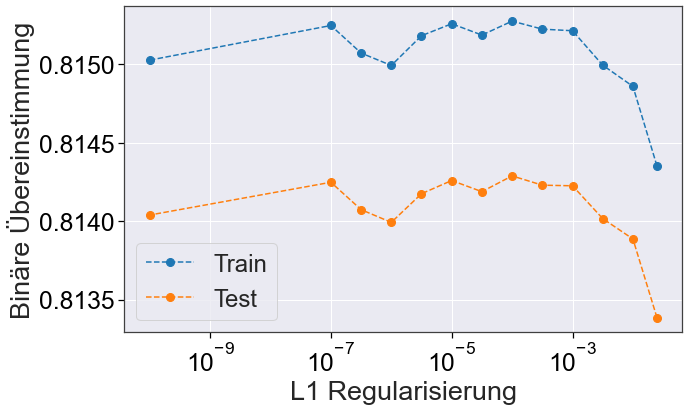

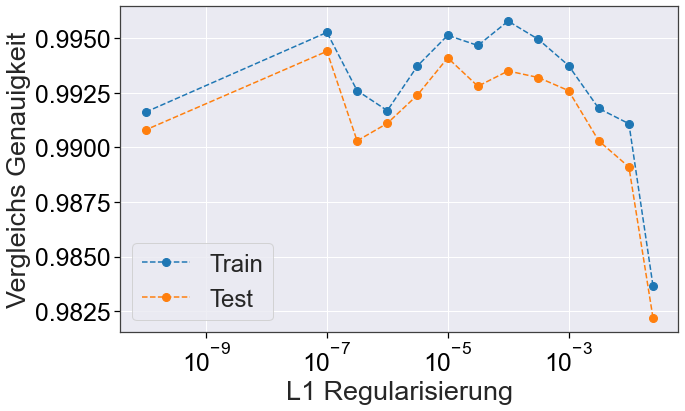

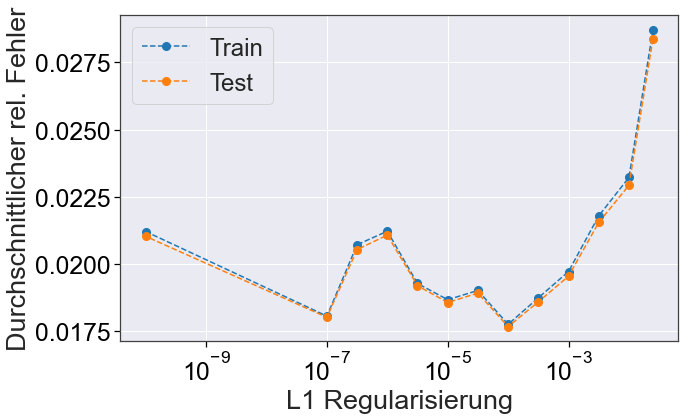

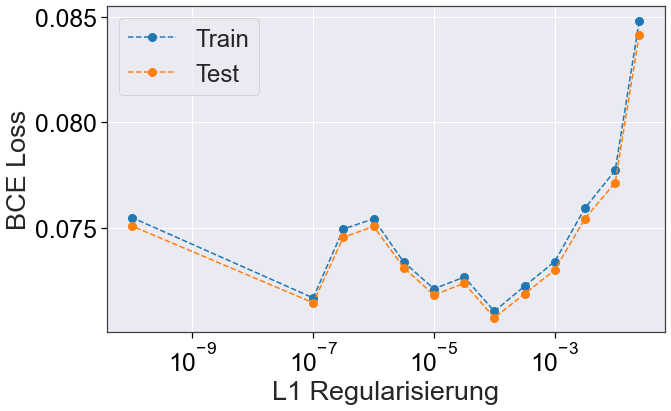

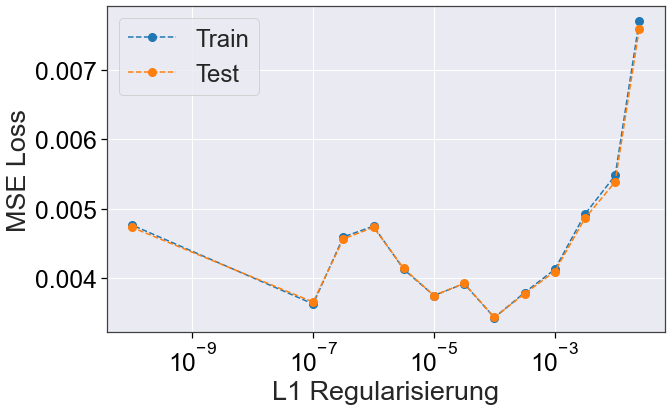

TSNE 2D silhouette Score not available


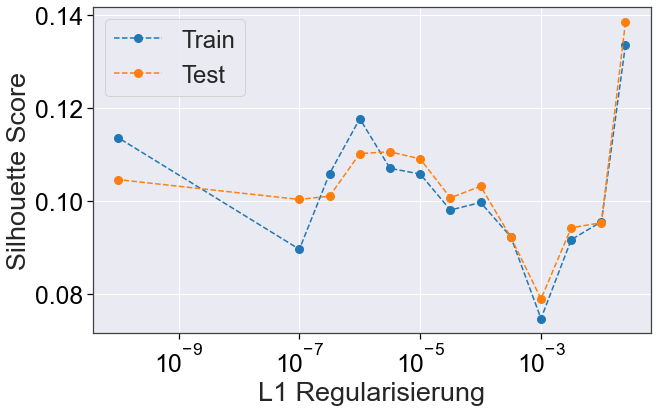

Silhouette Score - normalisiert not available


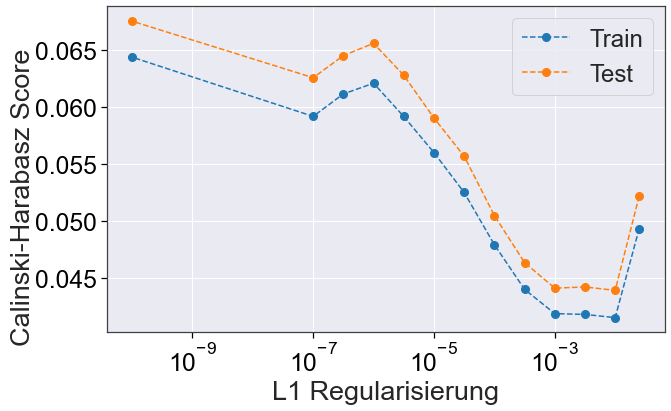

In [31]:
# %%% >>>> Plots general data <<<<

sns.set_palette("tab10")

plot_functions.fontscale(2.25, 24)
CalH_scale = dict(Train=len(XTrain), Test=len(XTest))

for i, (text, data, limits) in enumerate(plot_data):
    if data is None or (len(data['Test']) == 0 and len(data['Train']) == 0):
        print(text, "not available");
        continue

    #if text !=  "Calinski-Harabasz Score": continue

    fig = plt.figure(figsize=(10, 6))
    #plt.suptitle(text)
    #if PLOT_TEST_NAME:
    #    plt.title(TEST_NAME)

    # Set limits for plot

    if limits:
        ymin = np.min(np.concatenate((data['Test'],data['Train']))) if limits[0] is None else limits[0]
        plt.ylim(ymin, limits[1])

    # Plot Train and Test
    for train_test in ["Train", "Test"]:
        # if aborted eraly limit latent_size
        """ 
        # Old unscaled version with two plots
        if text == "Calinski-Harabasz Score":
            # Use 2 supplots as there can be quite some difference

            # Old non scale method with 2 supplots.
            ax = fig.add_subplot(211 if train_test == "Train" else 212)
            if train_test == "Train":
                ax.set_xscale('log' if X_TYPE == "DECODER_L1_VALUE" else 'linear')
                ax.set_xticklabels([])
                #plt.subplots_adjust(left=-0.5, right=1, wspace=0)
         """

        YData = np.array(data[train_test]) if text != "Calinski-Harabasz Score" else np.array(data[train_test]) / CalH_scale[train_test]
        
        if len(X_values) != len(YData):
            print("WARNING: X and Y data have not the same length for", text, "Plot might be shifted wrongly.")
            
        plt.plot(X_values, YData[:len(X_values)],
                 label=train_test, linestyle="--", marker="o", markersize=8,
                 c="C0" if train_test == "Train" else "C1")
        plt.legend()

    # Special ones
    if text == "Loss":
        plt.gca().invert_yaxis()

    if text != "Calinski-Harabasz Score":
        plt.ylabel(text)
    else:
        plt.ylabel("  ") # will be set manually below
        #plt.text(-26, data['Test'][0]//2, text, rotation='vertical')
        # Values are trial and error
        if X_TYPE == "LATENT_LAYER_SIZE":
            #plt.text(min(X_values) - 18, data['Test'][0]-150, text, rotation='vertical') # <-- non scaled version
            plt.text(min(X_values) - 20, 0.1,
                     text, rotation='vertical')
        else:
            # logplot for L1_Values
            #plt.text(0.02* min(X_values), YData[0], text, rotation='vertical') # L1
            plt.text(0.01* min(X_values), min(YData)*0.9, text, rotation='vertical') # L1

    if X_TYPE == "LATENT_LAYER_SIZE":
        plt.xlim(-2, X_values[-1]+5)

    set_xaxis()
    #plt.ylim(0.06, 0.41)
    plt.legend()
    plt.show()
    #plot_functions.save_plot(FULL_PLOT_PATH + text + "Latent 32 L1 Test.svg", fig, bbox_inches='tight')

In [29]:
X_values

[0.025,
 0.01,
 0.003162277660168,
 0.001,
 0.000316227766017,
 0.0001,
 3.16e-05,
 1e-05,
 3.16e-06,
 1e-06,
 3.16e-07,
 1e-07,
 1e-10]

## Singular Values and Variance




### Variance Niveaus

Plots the needed amount of singular values to reach the variance niveaus defined in Part A

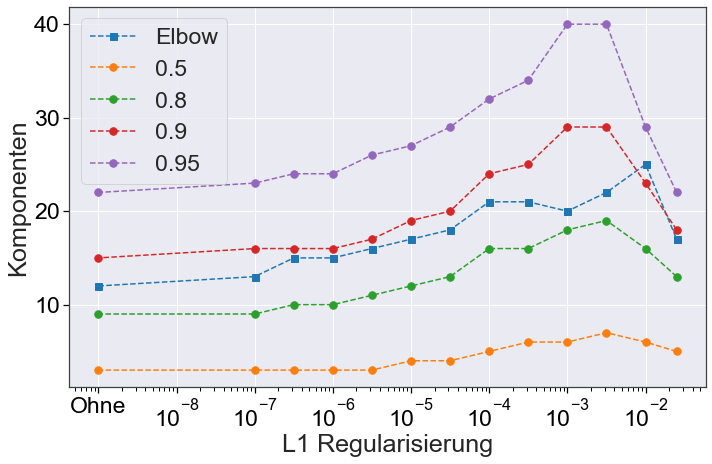

In [32]:
from matplotlib.ticker import ScalarFormatter


plot_functions.fontscale(2.10)
fig = plt.figure(figsize=(11.4, 7))
train_test = 'Train'        # NOTE: Train and Test are mostly equal within +- 1.
#for train_test in ["Train", "Test"]:
# MNISTplot with skip
#plt.plot(list(X_values[2:-2])+[150, 170], var_elbows[train_test][0:] , "--", marker='s', markersize=7, label="Elbow Values")
#plt.plot(list(X_values[2:-2])+[150, 170], var_niveaus[train_test][0:], "--", marker='.', markersize=15, label=train_test)

plt.plot([10**-9]+X_values[-2::-1], var_elbows[train_test][0:-1] , "--", marker='s', markersize=7, label="Elbow Values")
plt.plot(X_values[0:-1]+[10**-9], var_niveaus[train_test], "--", marker='.', markersize=15, label=train_test)

plt.ylabel("Komponenten")
plt.legend(["Elbow"]+var_test_niveaus)
set_xaxis()
ticks, labels = plt.xticks([10**-i for i in range(2,10)], ["$\mathdefault{10^{-"+str(i)+"}}$" for i in range(2,9)]+["Ohne"])
#locs, labels = plt.yticks()
#plt.yticks([*map(round, locs)][1:-1])
#plt.yticks(range(0,19,3))
#plt.xticks([0, 10, 28, 40, 64, 96, 128, 150, 170], [0, 10, 28, 40, 64, 96, 128, "...256", "...512"])
plt.show()

### Ratio of singular values

NOTE: This is optimized for a log scale and L1_VALUES

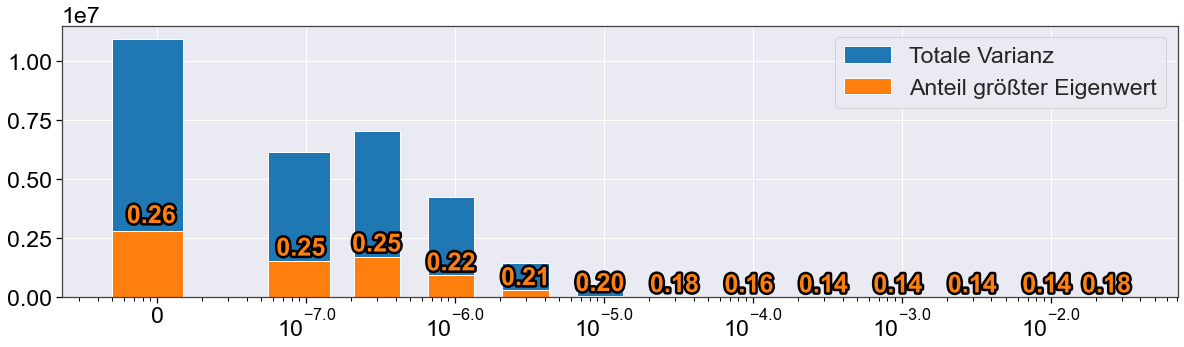

In [33]:
# %%%% Ratio first singular value Variance Niveaus
# Shoul d be done with an L1 Test
assert len(singular_values['Train']) > 0, "No singular values stored."
all_s = np.asarray(singular_values['Train'], dtype=object)
variances = all_s**2 #/ (all_s.shape[-1] - 1)
vars_summed =  [np.sum(var) for var in variances]
first_eigs = [var[0] for var in variances]
first_five = [np.sum(var[:5]) for var in variances]
first_20 = [np.sum(var[5:20]) for var in variances]
ratios = np.divide(first_eigs, vars_summed)

MIN_REL_VAR = 0.001

close0 = [sum(s < v*MIN_REL_VAR) for s,v in zip(all_s, vars_summed)]

xticks = X_values
xticks[-1] = 10**-9.5
xticks[-1] = 10**-8
widths = [*np.diff(xticks), -1e-9] # NOt used
widths[-1] = -10**-9



fig = plt.figure(figsize=(20, 5))
abs_rects = plt.bar(xticks, vars_summed, width=[*np.diff(xticks), -1e-8], label="Totale Varianz")
rects = plt.bar(xticks, variances[:, 0], width=[*np.diff(xticks), -1e-8], label="Anteil größter Eigenwert")
#Add Text
import matplotlib.patheffects as PathEffects
for i, r in enumerate(rects):
    if i != len(rects)-1:
        txt=plt.text(r.get_x() + r.get_width()/1.7, 2000+1.0*r.get_height(),
                 format(ratios[i], ".2f"), c="C1", label="R",
                 ha='center', va='bottom', rotation=0,
                 fontdict={
                     'weight' : 'bold'
                     })
    else:
        txt=plt.text(r.get_x() + r.get_width()/1.7, 1000+1.05*r.get_height(),
         format(ratios[i], ".2f"), c="C1", label="R",
         ha='center', va='bottom', rotation=0,
                          fontdict={
                     'weight' : 'bold'
                     })
    txt.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='black')])

plt.xscale('log')
#l = map(lambda s: format(s, "1.2e"), [0.025, *[10**-i for i in np.arange(2, 7.5, 0.5)], 0])
#plt.xticks(xticks, labels=l)
plt.legend()
#set_xaxis()
#mpl.rcParams['mathtext.fontset'] = 'custom'
#mpl.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
#mpl.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
#mpl.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
plt.xticks([*xticks[1::2], 10**-8], [r"$\mathdefault{10^{"+str(k)+"}}$" for k in np.log10(xticks[1::2])]+[0],)
#ticks = plt.xticks()
plt.show()
#plot_functions.save_plot(FULL_PLOT_PATH + "VarianzUndEigenwertAnteil.svg", fig, bbox_inches='tight')

### Amount of explained and neglectable Variance

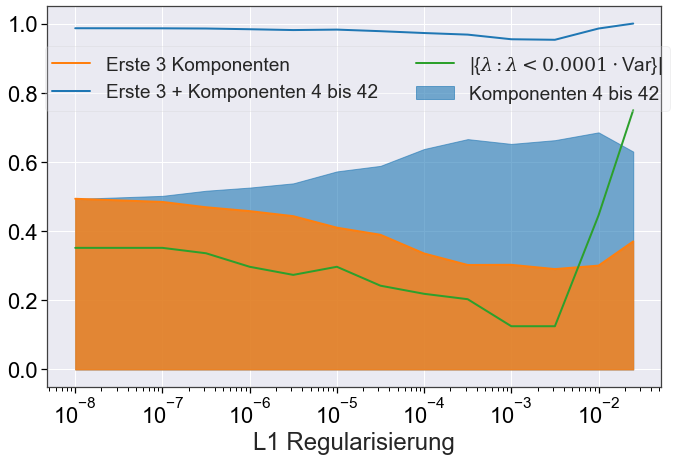

In [35]:
# %%%% Contour plot of variance

a,b = 3, 42
MIN_REL_VAR = 0.0001
close0 = [sum(s < v*MIN_REL_VAR) for s,v in zip(variances, vars_summed)]
first = np.divide([np.sum(var[:a]) for var in variances], vars_summed)
second = np.divide([np.sum(var[a:b]) for var in variances], vars_summed)

plot_functions.fontscale(2, 19)
fig2 = plt.figure(figsize=(11,7))
plt.plot(xticks, first,  label=f"Erste {a} Komponenten", linewidth=2, color="C1")
plt.plot(xticks, second + first, label=f"Erste {a} + Komponenten {a+1} bis {b}", linewidth=2, color="C0")
set_xaxis()
plt.plot(xticks,np.divide(close0, 128), color="C2",label="|{$\lambda : \lambda < "+format(MIN_REL_VAR, "g")+"\cdot$Var}|", linewidth=2)
plt.fill_between(xticks, second, alpha=0.6, color="C0", label=f"Komponenten {a+1} bis {b}")
plt.fill_between(xticks, first, 0, alpha=0.8, color="C1")
plt.legend(ncol=2, framealpha=0.25, loc='upper right', bbox_to_anchor=(1.03,0.92))
plt.show()
#plot_functions.save_plot(FULL_PLOT_PATH + "VerteilungEigenwerteVarianz.svg", fig2)

## Visualize pottential correlation between metrics

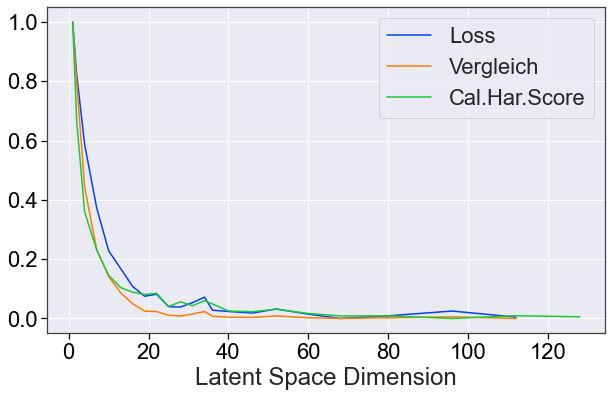

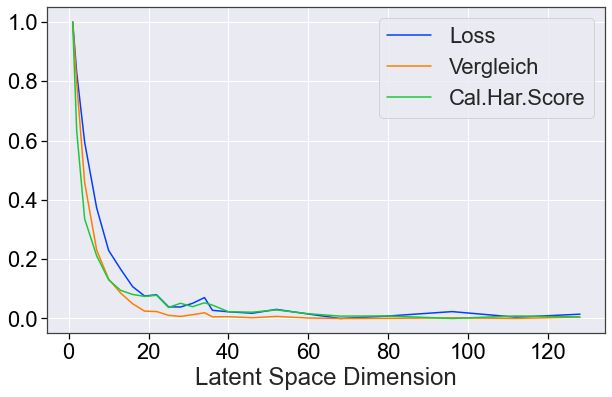

In [86]:
# %%% Compare Loss and others

# Loss vs model

def normit(data, min_to_zero=True):
    data = np.divide(data, min(data) if min_to_zero else max(data)) - 1 # 0 to min
    data = data / (max(data) if min_to_zero else min(data))             # 1 to max
    return data


r = (0, -2) # slice / range of the data. Here -2 to limit it to 1...128 instead of 512

for train_test in ["Train", "Test"]:
    fig = plt.figure(figsize=(10, 6))
    plt.plot(X_values[:len(bce_losses[train_test][r[0]:r[1]])], 
             normit(bce_losses[train_test][r[0]:r[1]]), label="Loss")
    plt.plot(X_values[:len(compare_accs[train_test][r[0]:r[1]])], 
             normit(compare_accs[train_test][r[0]:r[1]], False), label="Vergleich")

    if len(cal_har_scores[train_test]) > 0:
        plt.plot(X_values[:len(cal_har_scores[train_test][r[0]:r[1]])], 
                 normit(cal_har_scores[train_test][r[0]:r[1]]), label="Cal.Har.Score")
    #plt.xlabel("Latent Size")
    set_xaxis()
    plt.legend()
    plt.show()

    #plot_functions.save_plot(FULL_PLOT_PATH + "MetrikVergleich"+train_test + ".svg", fig, bbox_inches='tight')

## < PCA Plots >

These are again plots of major interest and show the change of the metrix depending on the latent layer size.

### Helperfunction to visualize dimension and loss difference to classic models

In [87]:
def plot_pca_vs_model(X, Y, pca_scores, model_scores, metrik_label="", test_name="", save=False):
    """
    Plots the differences between models with the same quality or dimension

    # For non functional / inline use:
    test_name = 'MNIST 5x5 Higher L1 -2.0 - Latent'
    pca_scores = pca_compare_results
    model_scores = compare_accs
    X = latent_sizes
    Y = compare_accs
    metrik_label = "Vergl. Genauigkeit"

    """
    #if metrik_label == "Calinski-Harabasz Score":
    #    return # Not usefull
    sns.set_palette('bright') # Todo can just increase the needed colors here
    X, pcaY = np.array(pca_scores['Test'][-3])
    orgY = np.array(model_scores['Test'])
    orgX  = np.array(latent_sizes[:25])
    # idx of shared values shared values
    closest = [np.argmin(np.abs(orgY[:10] - y)) for y in pcaY]
    Xdiffs = X - orgX[closest]

    max_i = min(41, len(Xdiffs)-2)
    X_skip = list(X[:-1])+[44]
    X_skip  = list(range(1, max_i+1)) + [44]

    shared_X = set.intersection(set(latent_sizes), set(X))
    pca_idx = [i for i in range(len(X)) if X[i] in shared_X]
    org_idx = [i for i in range(len(latent_sizes)) if latent_sizes[i] in shared_X]
    shared_X = sorted(shared_X)
    diff_pca_org : List[float] = np.abs(np.diff([pcaY[pca_idx], orgY[org_idx]], axis=0)[0]) # Differenz des Loss bei gleicher Modellgröße

    fig = plt.figure(figsize=(11, 7))
    plt.ylabel(r"$\Delta$"+ ylabel, usetex=0)
    plt.plot(shared_X[:-1] + [47] , diff_pca_org, ".--", markersize=20, linewidth=3,
             label="$|PCA_k - OhnePCA_{n=k}|$", color="C4")
    set_xaxis()
    plt.xticks(list(range(0,max_i+9,10)) + [47], list(range(0,max_i+9,10)) + ["...128"])
    plt.legend()
    plt.show()
    # no vsg names with the same filename!
    if save:
        plot_functions.save_plot(FULL_PLOT_PATH + metrik_label + "-PCAvsModel-Absolut-" + TEST_NAME[:len(TEST_NAME)//2] + ".svg", fig)

    ######

    if 1:
        # Find closest orginalY
         # as values vary at the end these should be limited to when the plateau is reached

        fig = plt.figure(figsize=(11, 9))
        plt.plot(orgX, orgY, ".--", markersize=10, label="ohne PCA")
        plt.plot(X, orgY[closest], ".--", markersize=10, label="PCA")
        set_xaxis()
        plt.xticks(range(0,128,4))
        plt.xlim(0, 40)
        plt.legend()
        plt.show()


        # ['dejavusans', 'dejavuserif', 'cm', 'stix', 'stixsans', 'custom']
        fig = plt.figure(figsize=(10, 7))
        plt.plot(orgX, orgY, "*--",
             markersize=20, markeredgecolor="black",alpha=1,
             label="ohne PCA", color="darkgray", linewidth=2)
        plt.plot(X, pcaY, ".--", markersize=15, label="PCA")
        a2=plt.annotate(text='', xy=(X[6],orgY[3]), xytext=(X[6],pcaY[6],),
                     label="$\Delta$Klassifikation",
             arrowprops=dict(arrowstyle='<->', linewidth=3, color="C4", alpha=1)
             )
        #plt.rc('text',usetex=1)
        plt.plot(0.5,1, color="C4",label="$\Delta$Klassifikation", linewidth=3)
        #plt.plot([orgX[2],orgX[3]],
        #         [orgY[2], pcaY[6]], "--",
        #         color="C1",label="Approximation", linewidth=3)
        a2=plt.annotate(text='', xy=(orgX[2]-0.1,pcaY[6]), xytext=(orgX[3]+0.1,pcaY[6]),
             label="$\Delta$Klassifikation",
             arrowprops=dict(arrowstyle='|-|', ls="-", hatch='.',linewidth=4, color="C5", alpha=0.75)
             )
        # label dummy
        plt.plot(0.5,1, "-", color="C5",label="$\Delta$Dimension", linewidth=3)
        set_xaxis()
        plt.ylabel(metrik_label)
        plt.xticks(range(0,128,4))
        plt.xlim(0, 37)
        plt.legend()
        plt.show()
        if save:
            plot_functions.save_plot(FULL_PLOT_PATH + metrik_label + "-DifferencesBetweenMethods-A" + TEST_NAME[:len(TEST_NAME)//2] + ".svg", fig)

        # Swapped axes
        fig = plt.figure(figsize=(10, 7))
        a1=plt.annotate(text='', xy=(orgY[2],X[6]+0.3), xytext=(orgY[2],latent_sizes[2]-0.3),
                     label="$\Delta$Dimension",
                     arrowprops=dict(arrowstyle='|-|', linewidth=4, color="C5", alpha=0.75),
                     )
        a1.set_label("$\Delta$Dimension")
        a2=plt.annotate(text='', xy=(orgY[3],X[6]), xytext=(orgY[2],X[6]),
                     label="Not used. Use dummy.",
             arrowprops=dict(arrowstyle='<->', linewidth=3, color="C4", alpha=1)
             )
        #
        a2.set_label("$\approx\Delta$Klassifikation")
        plt.plot(orgY[closest],X, ".--", markersize=15,
                 label="mit PCA", linewidth=2)
        plt.plot(orgY, orgX, "*--",
                 markersize=20, markeredgecolor="black",alpha=1,
                 label="ohne PCA", color="darkgray", linewidth=2)
        set_xaxis()
        plt.xlabel(metrik_label)
        plt.ylabel("Latent Size")
        plt.yticks(range(0,128,4))
        plt.ylim(0, 37)
        #
        #plt.vlines(orgY[2], X[6], orgX[2], linestyle="-", color="C3", label="$\Delta$Dimmension", linewidth=3)
        #plt.hlines(X[6], orgY[3], orgY[2], color="C4", linewidth=3, label="$\Delta$Klassifikation")
        # Dummys for legend
        plt.plot(0.5,1, color="C5",label="$\Delta$Dimension", linewidth=3)
        plt.plot(0.5,1, color="C4",label="≈$\Delta$Klassifikation", linewidth=3)
        plt.legend()
        #plt.legend(handles=legend.legendHandles, labels="abcd")
        #fig.axes[0].invert_yaxis()
        plt.show()
        if save:
            plot_functions.save_plot(FULL_PLOT_PATH + metrik_label + "-DifferencesBetweenMethods-" + TEST_NAME[:len(TEST_NAME)//2] + ".svg", fig)
        #return # <--- possible to break here

    # Reduction
    rel_reduction = list(Xdiffs / X * 100)
    rel_reduction = rel_reduction[:max_i] + rel_reduction[-1:]

    fig, ax = plt.subplots(figsize=(11, 8))
    set_xaxis()
    ax.plot(X_skip, Xdiffs[:max_i].tolist() + Xdiffs[-1:].tolist(),
             "--", markersize=20, marker=".", color="C5", linewidth=3,
             label="$k-n^*$")

    ylims=ax.set_ylim(min(Xdiffs)-1, Xdiffs[max_i-1]+2)
    #ax.set_yticks(range(0,21, 5))
    #ax.set_ylim(-1, 21)
    plt.xlim(-0.1, 45)
    plt.xticks(list(range(0,45,5))+[44], list(range(0,45,5)) + ["...128"])
    if metrik_label != "Calinski-Harabasz Score":
        ax.yaxis.get_major_locator().set_params(integer=True)
    plt.ylabel("Dimensionsunterschied" + ("\nbei " + metrik_label if metrik_label else ""))

    yax = plt.twinx()
    yax.plot(X_skip, rel_reduction, c="C9", markersize=8,
             linestyle="--", marker="s", label="Unterschied in %", linewidth=2.5)
    yax.set_yticks(range(0, 120, 20))
    ylims=np.asarray(ylims)
    yax.set_ylim(-6.5,110)
    yax.grid(b=None)
    yax.set_ylabel("%")
    ax.legend()
    yax.legend()
    plt.show()
    if save:
        plot_functions.save_plot(FULL_PLOT_PATH + metrik_label + "-PCAvsModel-Dimensionseinsparung-" + TEST_NAME[:len(TEST_NAME)//2] + ".svg", fig)


### Custom setup for PCA Plots

This section defines which values to skip or include in the plot.

In [95]:
#### Custom Settings
SWAP_XY = False # experimental, swap x and y axis if wanted

palette = sns.color_palette('bright') # Todo can just increase the needed colors here
# Adjust the pallete 
palette = list((sns.color_palette("bright", 7)))
palette.pop(-2)

palette = [c for c in palette[::-1] if not c[0]==c[1]==c[2]]  # remove gray
#palette[-2] = palette[-1]

#palette = [palette[0]] + palette[2:]
sns.set_palette(palette)
plot_functions.fontscale(2.25, 24)
plot_functions.fontscale(2.5, 27)

# NOTE use empty iterable not None for these variables
xlims = (None, None)
exclude = []
include = []
modulo_skip = 2

skiplesser = 20 # 10**-4.5
skipgreater= 1000  #1

Test_OR_Train = "Train" # Plot either Test or Train data, for both disable a if in the code below.

if TEST_NAME == 'MNIST 5x5 Higher L1 -2.0 - Latent':
    xlims = (None, 40)
    include = [10, 19, 128, 40, 28] # ggf 16
    exclude = [25]
    skipgreater = 40
    modulo_skip = 3

if TEST_NAME == "Circle Latent Test":
    palette = sns.color_palette('bright', 9) # Todo can just increase the needed colors here
    #palette = list(reversed(sns.color_palette("bright", 7)))
    palette = [c for c in palette[::-1] if not c[0]==c[1]==c[2]]  # remove grays
    #palette[-2] = palette[-1]
    sns.set_palette(palette)
    plot_functions.fontscale(2.4, 23) # BCE mit 26 vergleich keliner

    #palette = [palette[0]] + palette[2:]

    # NOTE use empty iterable not None
    xlims = (None, 21)
    exclude = []
    include = [3, 4, 5, 7, 10 , 13, 16]
    modulo_skip = 1

    skiplesser = 20 # 10**-4.5
    skipgreater= 1000  #1

# Triangle Test
if TEST_NAME == "Triangles Latent Test":
    modulo_skip = 2
    xlims = (0.5, 17.5)
    skiplesser = 2
    skipgreater= 8
    exclude = []
    include = [6, 8, 11, 17, 35]

if TEST_NAME in ('MNIST 64 L1 Test', 'MNIST Latent 32 L1 Test'):
    modulo_skip = 3
    xlims = (None, 40)
    skiplesser = 0
    skipgreater= 1000
    exclude = []
    include = []
    # NOTE: > 10**-5 are in decimal
    include =[1e-10, 0.025, 1e-2, 0.03162277660168379, 1e-3,1e-6]
    exclude =[0.003162277660168 ,10**-3.5, 0.000316227766017, 1e-7]

def skip_this(value, index):
    return ((index % modulo_skip
            or value in exclude
            or value < skiplesser or value > skipgreater)
            and value not in include)

def get_colors(amount, usedidx, X2, palette):
    """
    Get colors for plot.
    Skipped values are gray
    Plotted end/star values get the colors of the corresponding PCA plot'.
    """
    # Reapeat palette, todo: could use nicer itertools here
    all_colors = [c for c in palette * (amount // len(palette) + 1) ] # length is 10 * n
    # Sort colors by used
    #breakpoint()
    colors = ['darkgray'] * amount
    for cidx, i in enumerate(usedidx):
        colors[i] = all_colors[cidx]
    return colors


#### Choose which data to be plotted:

In [96]:
PCA_PLOTS = [ ## Logic: ("YAxis label", yvalues_by_pca, yvalues_whole_model, elbow_values_of_ydata)
              # --- Uncomment wanted tests ---
              #("BCE Loss" , pca_bce_losses, bce_losses, pca_bce_loss_elbows),
              #("Calinski-Harabasz Score", pca_cal_har_scores, cal_har_scores, pca_cal_har_elbows),
              #("MSE Loss", pca_mse_losses, mse_losses, None),
              ("Compare Accuracy", pca_compare_results, compare_accs, pca_compare_elbows)
              ]

# Set up x/y limits, None for auto
YLIMS = (None, None)
XLIMS = None # 
"""
Xlimits and range are tried to determined automatically
Custom values can be set up in the code below.

If there are big gaps in the Xdata like  16, 32, 128, 256 
it tries to insert ...256 with a smaller x skip
NOTE: This is currently removed but parts are still
there to rebuild it.
"""
pass

#### Plot choosen data

Note that sometimes the data needs a bit of tweaking to exclude outliers or set up the y and x range.

TODO: This is optimized for the classification and not for the others

skipping 1
skipping 2
skipping 4
skipping 7
skipping 13
skipping 16
skipping not included 22
skipping 25
skipping not included 31
skipping not included 36
skipping 46
skipping 52
skipping 60
skipping 68
skipping 80
skipping 96
skipping 112
skipping 256
skipping 512


C:\Anaconda\envs\myenv\lib\site-packages\matplotlib\cbook\__init__.py:1061: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asanyarray(x)


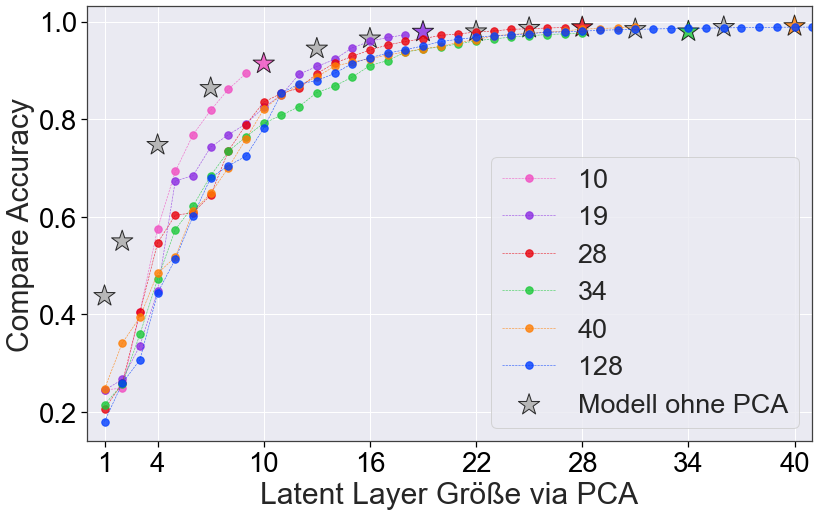

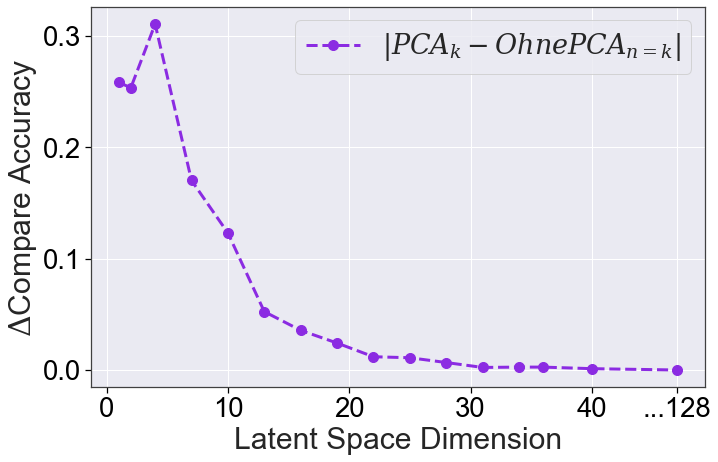

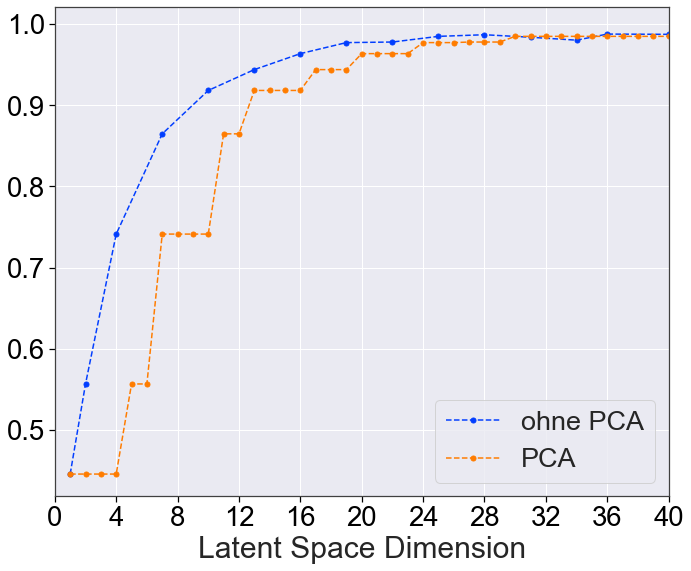

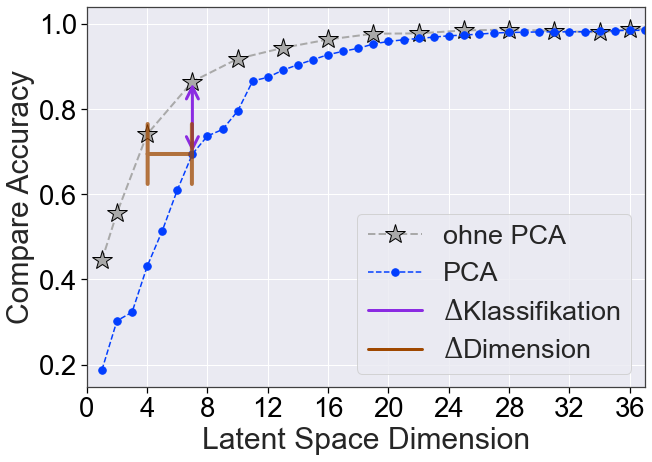

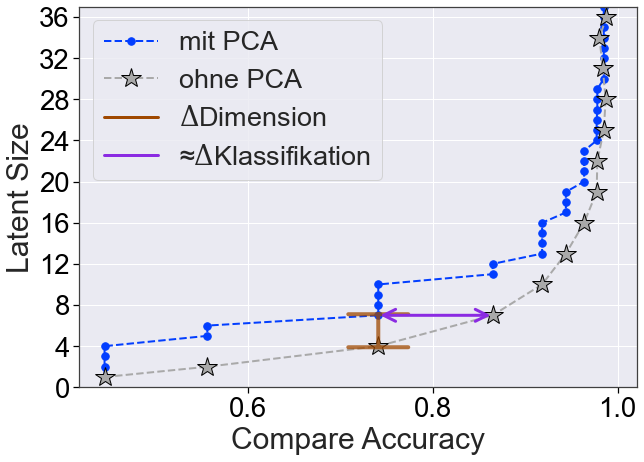

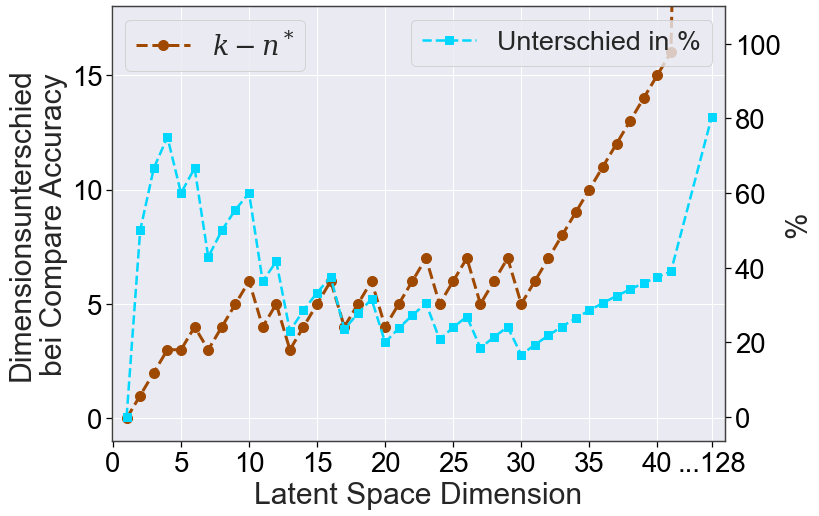

In [97]:
maxX = 0
nplots = 0

#### --Plot Loop--
for ylabel, pca_scores, model_scores, pca_elbows, in PCA_PLOTS:
    #if len(pca_scores['Test']) == 0:
    #    print("Skipping", ylabel)
    #    continue

    fig = plt.figure(figsize=(13, 8))
    if SWAP_XY:
        plt.ylabel("Latent Layer Größe via PCA")
        plt.yscale('linear')
        plt.xlabel(ylabel)
        fig.axes[0].invert_yaxis()
    else:
        plt.xlabel("Latent Layer Größe via PCA")
        plt.xscale('linear')
        plt.ylabel(ylabel)

    usedidx = []
    maxXlist = None
    for i, (x, test, train) in enumerate(zip_longest(X_values, pca_scores['Test'], pca_scores['Train'], fillvalue=[[None],[None]])):
        #if x != 128: # Note: Use this to plot a single
        #    continue
        if ((x < skiplesser or x > skipgreater) and x not in include) or x in exclude:
            print("skipping", x)
            continue
        if i % modulo_skip and x not in include :
            print("skipping not included", x)
            continue
        nplots += 1
        usedidx.append(i)

        train_X = train[0][0:-1] # -1 is the complete model, included below in Y2 therefore it's taken out
        train_Y = train[1][0:-1]
        test_X  = test[0][0:-1]  
        test_Y  = test[1][0:-1]
        if ylabel == "Calinski-Harabasz Score":
            # Scale data
            # NOTE MAYBE WAS ALREADY DONE
            train_Y = np.divide(train_Y, len(YTrain))
            test_Y = np.divide(test_Y, len(YTest))
            pass
        # Set which to plot as they are often quite much
        if Test_OR_Train == "Train":
            X = train_X
            Y = train_Y
        else:
            X = test_X
            Y = test_Y
        if len(X) == 0:
            print("X is empty. Skipping", x)
            continue

        # Determine max X list to be able to limit it
        maxXn = max(X)
        if maxXn >= maxX:
            maxX = maxXn
            maxXlist = X
            
        # ------- Manually tweak X axis -------
        #maxXlist = range(45)  # <--- Tweak here -------
        #maxX = 130            # <--- Tweak here -------
        
        if 1 and "Only Test for Train":
            # plot only one Type: Test or Train
            if len(X) >maxX:
                X = X[:maxX]
                Y = Y[:maxX]
            plt.plot(X if not SWAP_XY else Y, Y if not SWAP_XY else X, linewidth=0.6, linestyle="--", marker=".", markersize=15, alpha=0.8,
                     label=str(x) if X_TYPE == "LATENT_LAYER_SIZE" else\
                           model_names[-2::-1][i][-6:], # <-- NOTE might need customizeas l1 valus are ugly, todo make array.
                           )
        else: # plot train and test and elbows
            plt.plot(train_X, train_Y, linewidth=0.6, linestyle="--", marker=".", markersize=15, alpha=0.8,
             label="Train", # <-- NOTE might need customizeas l1 valus are ugly, todo make array.
                      c=(palette*5)[i+2]
                 )
            plt.plot(test_X, test_Y, linewidth=0.6, linestyle="--", marker=".", markersize=15, alpha=0.8,
             label="Test", # <-- NOTE might need customizeas l1 valus are ugly, todo make array.
                    c=(palette*5)[i+1]
                 )
            #plt.axvline(pca_elbows['Train'][i], c="C2", linestyle=":", label="(Train) Elbow bei "+str(pca_elbows['Train'][i]), linewidth=3)
            #plt.axvline(pca_elbows['Test'][i],  c="C1", linestyle=":", label="(Test) Elbow bei "+str(pca_elbows['Test'][i]), linewidth=3)

    # ############################
    #### Plot Values of whole models
    # ############################
    #X2 = [x for x in X_values if x <= X[-1]]

    if X_TYPE == 'DECODER_L1_VALUE':
        # This creates a gap in the axes, as the difference 40...128 can be quite big.
        # todo auto gap
        X = maxXlist
        if X[-1] != latent_sizes[i]:
            X = np.append(X, latent_sizes[i])
        gaps = np.diff(X)
        biggaps = np.where(gaps > 20)[0]
        if len(biggaps) > 0:
            new_ticks = [i for i in range(0, X[biggaps[0]], 5)]
            labels = new_ticks.copy()
            new_ticks += [new_ticks[-1] + 5, *[new_ticks[-1] + (5*(i+2)) for i in range(len(biggaps))]]
            labels += ["...", *X[biggaps[0]+1:]]

            if SWAP_XY:
                plt.yticks(new_ticks, labels)
            else:
                plt.xticks(new_ticks, labels)
            # Now normal data needs to be adjsuted
            X2 = [new_ticks[-1]] * len(usedidx)
            xlims = (0.5, new_ticks[-1] + 0.5)

            #plt.xticks([0, 10, 20, 30, 40, maxX if maxX > 45 else 0, maxX+3, maxX + 6],
            #lae    labels=[0, 10, 20, 30, 40, maxX if maxX > 45 else 0, "...", 128])           # TODO check
        else:
            X2 = [latent_sizes[i] for i in usedidx]

        Y2 = [model_scores[Test_OR_Train][i] for i in usedidx]
        #colors = all_colors[:len(X2)]
    else: # LATENT_LAYER_SIZE
        X2 = [x for x in latent_sizes if x <= maxX+1]
        Y2 = np.array(model_scores[Test_OR_Train][:len(X2)])
        #Y2 = np.array(model_scores['Train'][:len(X2)])
        # avoid floats:
        tick_list = range(int(np.floor(min(X2))), int(np.ceil(max(X2)))+1, 4)
        tick_list = [latent_sizes[i] for i in usedidx]
        #plt.xticks(tick_list)
        # OR
        if SWAP_XY:
            plt.yticks(latent_sizes[::2])
        else:
            plt.xticks(latent_sizes[::2])
        Y = train_Y
        X = train_X
        plt.xlim(0, maxX) # Trying to auto set x lim

    if ylabel == "Calinski-Harabasz Score":
        # Data must be scaled.
        Y2 = np.divide(Y2, len(YTest if Test_OR_Train == "Test" else YTrain))
        #Maybe adjust
        colors = get_colors(len(model_scores[Test_OR_Train]), usedidx, X2, palette)
        colors = [c for c in colors if c !="darkgray"]
        plt.ylim(None, 0.176) # 1 and 2 are out of the picture for train
    else:
        colors = get_colors(len(model_scores[Test_OR_Train]), usedidx, X2, palette) # both same length
    #colors = [c for c in colors if c != 'darkgray']

    plt.scatter(X2 if not SWAP_XY else Y2, Y2 if not SWAP_XY else X2, marker="*", s=500, label="Modell ohne PCA", edgecolor="black", c=colors[:len(X2)], alpha=0.8)
    #plt.legend([n[-6:] for n in model_names] + ["Modell ohne PCA"])
    if XLIMS:
        plt.xlim(*XLIMS) 
    if YLIMS:
        plt.ylim(*YLIMS)
    plt.legend()
    plt.show()

    plot_pca_vs_model(X, Y, pca_scores, model_scores, metrik_label=ylabel, test_name=TEST_NAME)
    #plot_functions.save_plot(FULL_PLOT_PATH + ylabel + "-viaPCAScaledUp" + TEST_NAME[:len(TEST_NAME)//2] + ".svg", fig, bbox_inches='tight')


0.2628819

---

## Plot Korrelation

of different metrics

In [100]:
r = (2, None) # slice for the data, to remove potential outliers at low dimensions

"""
Which variables and which labels.
todo: make this a dict.
"""
to_compare =(bce_losses, mse_losses, compare_accs, mean_rel_errors, cal_har_scores, silh_normed_scores, silh_scores_nd)
all_labels = ["BCE", "MSE", "Vergl.", "MRE", "C.H.S",  "Silh normed", "Silh mink"]


to_compare=(bce_losses, compare_accs, cal_har_scores, )
all_labels = ["BCE Loss", "Vergl.", "C.H.S",]

#
scores = [[s[train_test][r[0]:r[1]] for s in (to_compare) if len(s[train_test]) > 0] for train_test in ("Train", "Test")]
labels = [l for l,s in zip(all_labels, to_compare) if len(s['Trai']) > 0]

corr = np.mean([np.corrcoef(np.vstack(scores[0])),  np.corrcoef(np.vstack(scores[1]))], axis=0)

fig = plt.figure()
ax = sns.heatmap(corr, cmap='coolwarm', vmin=-1, vmax=1, center=0,
                 xticklabels=labels, yticklabels=labels,
                 annot=True, linewidths=.5, cbar_kws={"ticks": [-1, 0, 1]})
plt.yticks(rotation=0)
plt.show()
#plot_functions.save_plot(FULL_PLOT_PATH + "KorrelationMethoden.svg", fig)

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 22 and the array at index 2 has size 23

In [230]:
# %% # Korrelation with loss

corrs = []
for a, b in zip(np.array(pca_bce_losses['Train'], dtype=object)[2:, 1],
                np.array(pca_cal_har_scores['Train'], dtype=object)[2:, 1]):
    corrs.append(np.corrcoef(a[:min(len(a), len(b))], b[:min(len(a), len(b))])[1,0])

print(np.mean(corrs))

np.corrcoef(bce_losses['Test'][2:], cal_har_scores['Test'][2:])[1,0]

print(np.mean(corrs))

0.9026924635828633
0.9026924635828633


# < Plots of a single model >

This is again a major part.
This will take samples of the different classes in the data for the different latet layer sizes of _one_ chosen model.

### Define the indices at which the samples should be taken:

In [102]:
rangemax = None
sns.set_palette("tab10")

##

USE_IDX = 0 # 0 for triangles
# 3 : 0 +1

used_samples = {'Train':[], 'Test':[]}
used_samples['Train'].append(XTrain[USE_IDX])
used_samples['Test'].append(XTest[USE_IDX])
# NOTE: Index 0 is original, set above
SAMPLE_IDXS = [2,3,4,5,6,7,8,18] # for triangles
SAMPLE_IDXS = list(range(1, 7)) + [20] # for circles

used_pca_samples = {'Train': [],
                    'Test' : []}
eigw_elbows = []
eigw_elbows_test = []

if TOPIC == 'MNIST':
    # Special to take more samples of each digit
    def sample_class_indices(labels, shift=0):
        """
        Returns indices where to take a single sample of each label
        """
        # Sort labels
        labels = np.array(labels).flatten() # have a copy here
        names, first_idx = np.unique(labels, return_index=True) # Starting indices of labels
        if shift > 0:
            results = []
            for n in names:
                results.append(np.where(labels == n)[0][shift])
            return results

        return first_idx
     # take first occuring sample


    train_sample_idx = sample_class_indices(YTrain, shift=1)
    test_sample_idx  = sample_class_indices(YTest, shift=1)

    mnist_samples = np.append(train_sample_idx, test_sample_idx)
    # Take each digit fr
    USE_IDX = mnist_samples

    used_samples = {'Train':[], 'Test':[]}
    used_samples['Train'].append(XTrain[USE_IDX]) # a 0
    used_samples['Test'].append(XTest[USE_IDX]) # a 1


#### Helper functions for plotting

In [156]:
def plot_full_model_samples(samples, used_indices=SAMPLE_IDXS, sample_texts=None):
    """This function is depracted use the one below"""
    fig, axes2 = plt.subplots(2, len(used_indices)+1, sharex=True, sharey=True,
                               figsize=(2*len(used_indices)+1, 9),)

    fig.suptitle("Latent Layer Size", fontsize=25)
    for row_n, train_test in enumerate(['Train', 'Test']):
        axline = axes2[row_n]
        ax = axline[0]
        plot_functions.ax_plot_digit(ax, samples[train_test][0]) # original
        if row_n == 0:
            ax.set_title("Original", fontsize=28)
        ax.get_yaxis().set_visible(True)
        ax.set_yticks([])
        ax.set_ylabel(train_test, fontsize=30) # axes are shared

        if sample_texts is None:
            sample_texts = used_indices
        for j, (latent_size, text) in enumerate(zip(used_indices, sample_texts), start=1):
            print(np.shape(samples[train_test][latent_size]))
            ax = axline[j]
            plot_functions.ax_plot_digit(ax, samples[train_test][latent_size][0])
            if row_n == 0:
                ax.set_title(str(text), fontsize=28)

    fig.tight_layout(h_pad=-10)
    fig.subplots_adjust(top=1.35, wspace=0.1,)
    plt.show()
    return fig

# %%% Plotting multiple different samples in a (y)types X (x)samples_of_type grid
#     NOTE: Behavior might change in upcoming matplotlib versions!
def plot_multiple_samples(samples, amount_samples:len(USE_IDX),
                          used_indices=SAMPLE_IDXS, sample_texts=None,
                          filename=None, show=False, title="Latent Layer Size"):
    """
    When multiple samples have been taken for the same model.

    amount_samples should be same as len(USE_IDX)
    Help see: https://matplotlib.org/devdocs/api/figure_api.html#matplotlib.figure.Figure.subfigures
    NOTE: Behavior might change in upcoming matplotlib versions!

    Using the fig.savefig does not to work in the current version.
    Also svgs creates a large border on the right.
    Saves as svg and png if filename is provided
    """
    # Todo in upgraded version
    ## Setting title does not work
    mainfig = plt.figure(figsize=(2*len(used_indices), 3*amount_samples))

    subfigs = mainfig.subfigures(amount_samples+1, 1, height_ratios=[0.2, *[1]*amount_samples])
    # Some strange necessary hacking to get the title
    sfig = subfigs[0]
    ax = sfig.subplots()
    #ax.plot(range(3))
    dummy = np.ones((1,1))
    dummy[0,0]=1
    ax.imshow(dummy, cmap='binary')
    #ax.set_title(title, fontsize=17)
    ax.axis('off')
    # maybe mainfig.suptitle works in newer versions
    for s in range(amount_samples):
        sfig = subfigs[s+1]
        axes2 = sfig.subplots(2,
                    len(used_indices)+1,
                    sharex=True, sharey=True,
                    #figsize=(2*len(used_indices)+1, 9),
                    )
        #if s == 0:
        #    sfig.suptitle("Latent Layer Size", fontsize=25)
        for row_n, train_test in enumerate(['Train', 'Test']):
            axline = axes2[row_n]
            ax = axline[0]
            plot_functions.ax_plot_digit(ax, samples[train_test][0][s]) # original
            if row_n == 0 and s == 0:
                ax.set_title("Original", fontsize=17)
            ax.get_yaxis().set_visible(True)
            ax.set_yticks([])
            #ax.set_ylabel(train_test, fontsize=30) # axes are shared

            if sample_texts is None:
                sample_texts = used_indices
            for j, (latent_size, text) in enumerate(zip(used_indices, sample_texts), start=1):
                ax = axline[j]
                plot_functions.ax_plot_digit(ax, samples[train_test][latent_size][s])
                if row_n == 0 and s == 0:
                    ax.set_title(str(text), fontsize=17)

    mainfig.subplots_adjust(left=-.5, top=1.05, bottom=0.05, wspace=-0.89, hspace=0.1)
    #mainfig.tight_layout()
    if filename:
        #plt.savefig(filename, bbox_inches='tight', pad_inches=0)
        plt.savefig(filename, format='svg', bbox_inches='tight', pad_inches=0.0)
    if show:
        plt.show()
    return mainfig

### Take samples for models and dimension reduction with PCA

This can be usefull for one or multiple models.
But I recommend to use one model only or on a dataset with a low latent space.


In [104]:
model_names

['MNIST 5x5 Higher L1 -2.0 - Latent 1',
 'MNIST 5x5 Higher L1 -2.0 - Latent 2',
 'MNIST 5x5 Higher L1 -2.0 - Latent 4',
 'MNIST 5x5 Higher L1 -2.0 - Latent 7',
 'MNIST 5x5 Higher L1 -2.0 - Latent 10',
 'MNIST 5x5 Higher L1 -2.0 - Latent 13',
 'MNIST 5x5 Higher L1 -2.0 - Latent 16',
 'MNIST 5x5 Higher L1 -2.0 - Latent 19',
 'MNIST 5x5 Higher L1 -2.0 - Latent 22',
 'MNIST 5x5 Higher L1 -2.0 - Latent 25',
 'MNIST 5x5 Higher L1 -2.0 - Latent 28',
 'MNIST 5x5 Higher L1 -2.0 - Latent 31',
 'MNIST 5x5 Higher L1 -2.0 - Latent 34',
 'MNIST 5x5 Higher L1 -2.0 - Latent 36',
 'MNIST 5x5 Higher L1 -2.0 - Latent 40',
 'MNIST 5x5 Higher L1 -2.0 - Latent 46',
 'MNIST 5x5 Higher L1 -2.0 - Latent 52',
 'MNIST 5x5 Higher L1 -2.0 - Latent 60',
 'MNIST 5x5 Higher L1 -2.0 - Latent 68',
 'MNIST 5x5 Higher L1 -2.0 - Latent 80',
 'MNIST 5x5 Higher L1 -2.0 - Latent 96',
 'MNIST 5x5 Higher L1 -2.0 - Latent 112',
 'MNIST 5x5 Higher L1 -2.0 - Latent 128',
 'MNIST 5x5 Higher L1 -2.0 - Latent 256',
 'MNIST 5x5 Highe

In [118]:
selected_model_names = ['MNIST 5x5 Higher L1 -2.0 - Latent 128']
selected_model_names = model_names # <-- adjust if you just want to run it for a single model
selected_model_names = ['MNIST 5x5 Higher L1 -2.0 - Latent 128']

PLOT_OUTPUT_SAMPLE = False  # TODO: Something is wrong there currently and also it's not that interesting
CALC_EIGENVALUES =1 # some additional plots and data done in Part A, Note this are not for MNIST

loading model MNIST 5x5 Higher L1 -2.0 - Latent 128
Stopping, changes were under min_rel_change. Only adding last value
Stopping, changes were under min_rel_change. Only adding last value
117


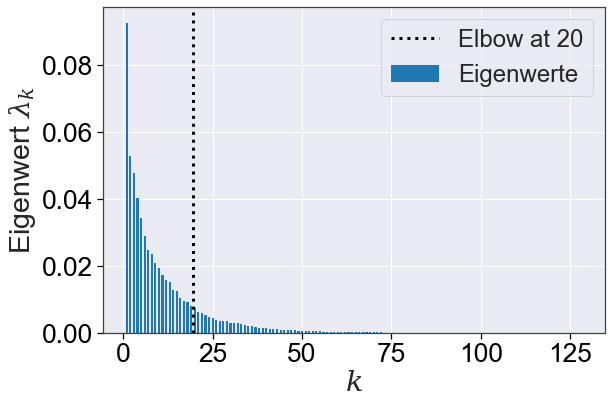

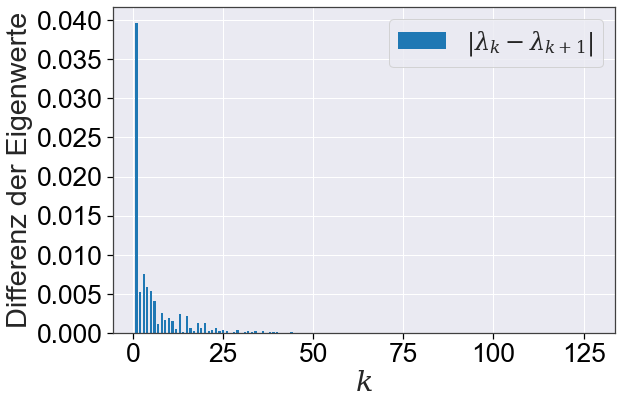

In [232]:
for name in selected_model_names:
    print("loading model", name)
    autoencoder = tf.keras.models.load_model(MODEL_PATH+name)
    encoder = tf.keras.models.Sequential(autoencoder.layers[:-1], name="LoadedEncoder")
    decoder = autoencoder.layers[-1]  # Sequential

    EncodedTest = encoder.predict(XTest)
    EncodedTrain = encoder.predict(XTrain)

    #DecodedTest = EncodedTest
    #DecodedTrain = EncodedTrain
    # NOTE: Comment out the next lines if decoded is not needed for single use test.
    DecodedTest = decoder.predict(EncodedTest)
    DecodedTrain = decoder.predict(EncodedTrain)

    #### Plot actual results of data
    # ### Take Samples and plot them
    # Also optionally plot multiple samples at the end of the test.
    used_samples['Test'].append(DecodedTest[USE_IDX])
    used_samples['Train'].append(DecodedTrain[USE_IDX])

    if PLOT_OUTPUT_SAMPLE:
        # Plot 2x2 Input Output
        fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(9, 9))
        fig.suptitle("Latent Size " + str(EncodedTest.shape[-1]),   fontsize=25)
        # original

        for row_n, train_test, original, decoded in zip([0, 1],
                                                 ['Train', 'Test'],
                                                 [XTrain, XTest],
                                                 [DecodedTrain, DecodedTest]):
            # Original
            ax = axes[row_n][0]
            plot_functions.ax_plot_digit(ax, original[USE_IDX])
            if row_n == 0:
                ax.set_title("Original")
                ax.set_yticks([])

            ax.set_ylabel(train_test) # axes are shared
            ax.get_yaxis().set_visible(True)
            # Decoded
            ax = axes[row_n][1]
            plot_functions.ax_plot_digit(axes[row_n][1], decoded[USE_IDX])
            if row_n == 0:
                ax.set_title("Output")
            #used_samples[train_test].append(decoded[USE_IDX])
        plt.show()
        #plot_functions.save_plot(FULL_PLOT_PATH+"Outputs/"+name, fig)

        # Plot all digits in one plot
        if name == model_names[-1]:
            fig = plot_full_model_samples(used_samples, SAMPLE_IDXS)
            #plot_functions.save_plot(FULL_PLOT_PATH+"Outputs/"+"SampledCircle-Full.svg", fig, bbox_inches='tight')

    # ### Singular / Eigenvalues -fit PCA

    pca_train = tf_PCA()
    pca_train.fit(EncodedTrain)
    pca_test = tf_PCA()
    pca_test.fit(EncodedTest)

    # ### PCA Samples ----

    for train_test, original, encoded, pca in zip(['Train', 'Test'],
                                                          [XTrain, XTest],
                                                          [EncodedTrain, EncodedTest],
                                                          [pca_train, pca_test]):
        if TOPIC == 'MNIST':
            sample_dict = {'indices':train_sample_idx if train_test == 'Train' else test_sample_idx}
        else:
            sample_dict = {'indices':[USE_IDX] if type(USE_IDX) == int else USE_IDX}
        pca_tests(original, encoded, decoder, pca=pca, verbatim=0,
            start=1,
            test_funcs={},
            min_rel_changes=[],
            take_samples = sample_dict,
            min_samples=30
        )
        # Plot some outputs
        if False and encoded.shape[-1] != 1 and model_names.index(name) < 10: # plot only first 10
            # no value for latent 1, original is not appended here
            plot_functions.plot_image(sample_dict[USE_IDX if type(USE_IDX) == int else USE_IDX[0]][-1])
            plt.show()
        used_pca_samples[train_test].append(sample_dict)

    if not CALC_EIGENVALUES:
        continue
        
    pca = pca_train

    eigw = pca.S**2/128
    eigdiff = np.diff(eigw)
    eigw_elbow = calculate_elbow(eigw, range(1, len(eigw)+1))
    eigw_elbows.append(eigw_elbow)
    tol_val = pca.S[-1]*4
    tol_idx = np.argmax(pca.S < tol_val)
    print(tol_idx)
    singular_values[train_test].append(pca.S.numpy()) # Note: also avaliable in Main Test Loop

    ####  Singular / Eigenvalues - plot

    #plt.rc('text', usetex=True) # LaTeX on

    fig = plt.figure(figsize=(9,6))
    rangemax is not None and plt.xlim(0, rangemax)
    plt.bar(range(1, len(eigw)+1), eigw, width=0.6, edgecolor="None", label="Eigenwerte")
    plt.rc('text', usetex=False)
    plt.ylabel("Eigenwert $\lambda_k$")
    set_xaxis()
    plt.xlabel("$k$")
    #plt.axhline(eigw_elbow, c="cornflowerblue", linestyle="--", alpha=0.5, label="$\lambda_1\cdot0.01$")
    #plt.axvline(eigw_elbow+0.5, c="C1", linestyle=":", label="Elbow bei "+str(eigw_elbow), linewidth=3)
    plt.axvline(eigw_elbow-0.5, c="black", linestyle=":", label="Elbow at "+str(eigw_elbow), linewidth=3)
    #plt.axhline(eigw[40], c="green", linestyle="--", label="rel. Änderung < 0.05 bei $k=$" +str(40), linewidth=2)
    plt.legend()
    plt.xscale('linear')
    plt.show()
    #plot_functions.save_plot(FULL_PLOT_PATH+"Eigenwerte/"+TEST_NAME+"+name[-6:]+".svg", fig, bbox_inches='tight')
   

    fig = plt.figure(figsize=(9,6))
    rangemax is not None and plt.xlim(0, rangemax)
    plt.bar(range(1, len(eigdiff)+1), np.abs(eigdiff), width=0.6, edgecolor="None", label=r"$|\lambda_k - \lambda_{k+1}|$")
    #plt.axvline(eigw_elbow-0.5, c="black", linestyle=":", label="Sprung bei "+str(eigw_elbow-1), linewidth=3)
    #plt.axvline(8.5, c="black", linestyle=":", label="Sprung bei "+str(8), linewidth=3)
    plt.ylabel("Differenz der Eigenwerte")
    set_xaxis()
    plt.xscale('linear')
    plt.xlabel("$k$")
    ax = plt.gca()
    ax.yaxis.set_major_locator(MaxNLocator(integer=True)) # integer y axis
    #ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    #plt.xticks(range(4,21,4))
    plt.legend()
    plt.show()
    #plot_functions.save_plot(FULL_PLOT_PATH+"Eigenwerte/"+TEST_NAME+name[-6:]+".svg", fig, bbox_inches='tight')

    plt.rc('text', usetex=False)

################################

In [117]:
USE_IDX

array([21,  6, 16, 10,  9, 11, 18, 29, 31, 19, 10,  5, 35, 30,  6, 15, 21,
       17, 84,  9], dtype=int64)

## < Plot Samples >

After the samples where taken the following cell can be used for plotting.
Test specific values can be set up here.

TODOs:
* The samples could also be taken in Part A. (That's why this cell is up here)
* Store samples to the drive

### Plot Outputs of multiple models

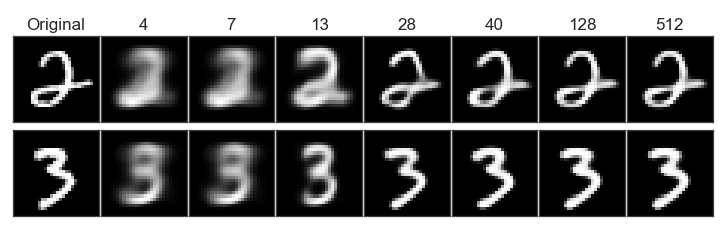

In [161]:
## Sample of one model
# Which numbers/ classes to plot
CLASS_IDX1 = 2
CLASS_IDX2 = 3 
MODEL_ROOT_NAME = 'MNIST 5x5 Higher L1 -2.0 - Latent ' # + number that is missing see below

# =======================

# Which model to choose
if TEST_NAME =='MNIST 64 L1 Test' or X_TYPE == 'DECODER_L1_VALUE':
    SAMPLE_IDXS = [*range(1, 11, 4), -4, -3,-2,-1]
    latent_samples = ["0.0" ,*["$10^{"+model_names[i][-4:]+"}$" for i in SAMPLE_IDXS[1:-2]], 0.025, "$10^{-1.5}$"]
else:
    latent_samples = [4, 7, 13, 19, 28, 128, 512]
    latent_samples = [4, 7, 13, 28, 40, 128, 512]
    # get correct indices by model name
    # >>> NOTE adjust for other model names <<<
    SAMPLE_IDXS = [model_names.index(MODEL_ROOT_NAME +str(i)) for i in latent_samples] # MNIST

limited_samples = {'Train':[], 'Test':[]}

for row in used_samples['Train']:
    limited_samples['Train'].append(row[CLASS_IDX1 : CLASS_IDX1+2:2]) #  <-- even numbers, adjust to 2 for other numbers

for row in used_samples['Test']:
    limited_samples['Test'].append(row[CLASS_IDX2 +10 : CLASS_IDX2 +12:2])    # <-- odd numbers

fig=plot_multiple_samples(limited_samples, 1, SAMPLE_IDXS, sample_texts=latent_samples,
                          title="L1 Value" if X_TYPE == 'DECODER_L1_VALUE' else 'Latent Layer Size');
#plot_functions.save_plot(FULL_PLOT_PATH+"Sampled-MNIST-Latent-One Sample Full.svg", fig, bbox_inches='tight')


### Plot PCA reduction of all classed for one model

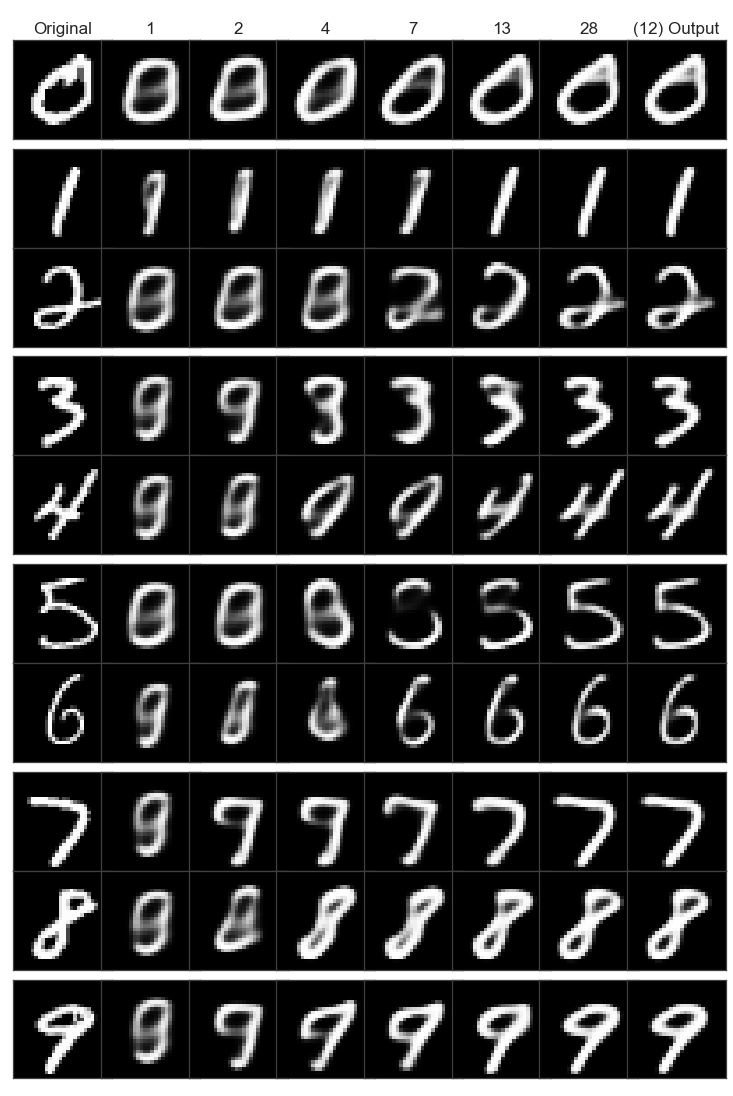

In [158]:
####################
# Plot for pca of a single model
####################

SAMPLE_IDXS = [2, 4, 7, 13, 19, 24, -1]
SAMPLE_IDXS = [4, 7, 13, 19, 28, 31, -1]
model_index  = model_names.index('MNIST 5x5 Higher L1 -2.0 - Latent 128') #<--- Choose which model

SAMPLE_IDXS = [1, 2, 4, 7, 13, 28, -2] # For L1
model_index=-1

#pca_sampled_idx =
import copy
limited_samples = {'Train':[], 'Test':[]}
for train_test, indices, slicer in zip(['Train', 'Test'],
                                       (train_sample_idx, test_sample_idx),
                                       [slice(0,None,2), slice(1,None,2)]): # adjust start for other numbers
    data = copy.deepcopy(used_pca_samples[train_test][model_index])
    for i in indices[slicer]:
        # add original and full sample
        # MNIST orgiginal are not used in used_sample, need to index it right
        # also doubles can occure
        data[i].insert(0,
            used_samples[train_test][0][np.where(mnist_samples==i)[0][0 if train_test == 'Train' else -1]])

        data[i].append(
            used_samples[train_test][-1][np.where(mnist_samples==i)[0][0 if train_test == 'Train' else -1]])

    train_samples = np.asarray([data[i] for i in indices[slicer]]) # even
    limited_samples[train_test] = np.swapaxes(train_samples, 0, 1)

f"({model_names[model_index][-2:]}) Output"
fig=plot_multiple_samples(limited_samples, 5, SAMPLE_IDXS, 
                          sample_texts=[*SAMPLE_IDXS[:-1], f"({model_names[model_index][-2:]}) Output"])
#plot_functions.save_plot(FULL_PLOT_PATH+"Sampled-MNIST-32L1-PCA_Verlauf 1e-1.5 Full.svg", fig=fig, bbox_inches='tight')
plt.show()

# Suggested latent sizes by metrics


## Elbow values of metrics

Note that because the Calinski-Harabasz Score is not stable for low dimensions
some values are excluded and values between 1 and 4 are sometimes to be skipped.

Note: That the calculation can be done in Oart A as well 
and therefore the optional cell below to load the data if it already exists


In [226]:
test_name

'Klassifikationsmodell'

In [233]:
latent_dims

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 128]

In [256]:
# %% Calulate all loss elbows
"""
# Now in main loop. Depracted in the future
# Use START to skip 1 or 2 of the first values as they might not be represantative
# for example if they represent latent size 1
# That's also why for the Calinski-Harabasz Score certain outliers are skipped
"""
START=2
elbows = {"Loss" : {'Train':[], 'Test':[], 'test_data': pca_bce_losses.copy()},
          "Calinski-Harabasz Score" : {'Train':[], 'Test':[], 'test_data': pca_cal_har_scores.copy()},
          'Klassifikationsmodell' : {'Train':[], 'Test':[], 'test_data': pca_compare_results.copy()},
          }


#for train_test in ["Test", "Train"]:
for train_test in ["Test"]:
    for test_name, test_dict in elbows.items():
        i=0
        test_data = test_dict['test_data']
        for latent_dims, values in test_data[train_test][START:]: # might need to make it smaller
            # Esclude 2nd value as these sometimes differ
            i += 1
            if 0:
                if test_name == 'Klassifikationsmodell':
                    values = values[0:]
                    i +=1
                    latent_dims = latent_dims[0:]
                if test_name ==  "Calinski-Harabasz Score":
                    # Skip Minima for < 4 as these sometimes yield wrong results
                    # Value 1,2,3 are sometimes unsafe to use.
                    if latent_dims[-1] == 512:
                        latent_dims = latent_dims[1:]
                        values = values[1:]
                    else:
                        latent_dims = latent_dims[:1]+latent_dims[5:]
                        values = values[:1]+values[5:]
                    if values is None: 
                        continue
            if len(values) == 0:
                continue
            elbow = calculate_elbow(values, latent_dims)
            test_dict[train_test].append(elbow)


#### Load elbows if avaiblable

Only execute this cell if the data was loaded / stored to a npz file.

In [209]:
START=2
elbows = { 'Loss'                    : pca_bce_loss_elbows.copy(),
           'Calinski-Harabasz Score' : pca_cal_har_elbows.copy(),
           'Klassifikationsmodell'   : pca_compare_elbows.copy(),}

### Plot Elbow values

<Figure size 864x432 with 0 Axes>

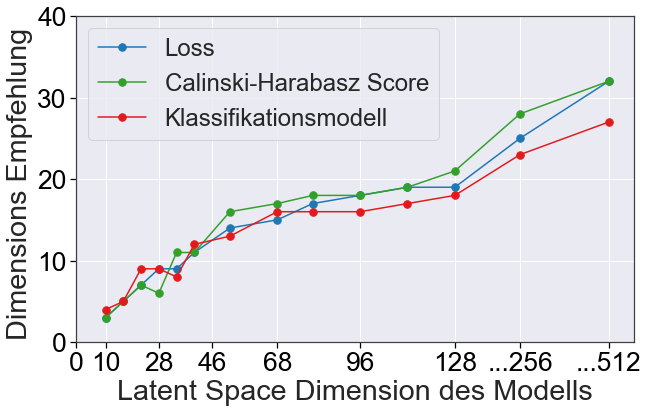

In [255]:
plot_functions.fontscale(2, 22)
sns.set_palette("Paired")
sns.set_palette(sns.color_palette("Paired")[1::2])
fig = plt.figure(figsize=(12,6))
fig = plt.figure(figsize=(10,6))
plot_functions.fontscale(2.4, 24)
# Adjust high X_values

for test_name, test_dict in elbows.items():
#    for train_test in ["Test", "Train"]: # saturated values are Train values
    for train_test in ["Test"]: # saturated values are Train values
        if X_TYPE == 'DECODER_L1_VALUE':
            plt.plot(X_values[START:], test_dict[train_test], ".-", markersize=15,
             label=test_name if train_test == "Train" else None)
        else:
            # Use less points and skip first but include last
            plotX=list(latent_sizes[START:-6:2])+list(latent_sizes[-6:-2]) + [150, 180]
            plotY=list(test_dict[train_test][START:-6:2]) + test_dict[train_test][-6:]
            plotX = plotX[-len(plotY):]
            plt.plot(plotX,
                     plotY, ".-", markersize=15,
                     label=test_name)
            #plt.plot(latent_sizes[:len(test_dict[train_test])], test_dict[train_test], ".-", markersize=15,
                     #label=test_name)


ax = plt.gca()
from matplotlib.ticker import MaxNLocator
#ax.yaxis.set_major_locator(MaxNLocator(integer=True)) # integer y axis
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
#plt.xticks(range(0, 550, 50), range(0, 550, 50))
#plt.xlabel("Latent Size of Model")

plt.ylabel("Dimensions Empfehlung ")
plt.legend(loc='upper left')
plt.legend()
plt.ylim(0, 40)
plt.xscale('linear')
set_xaxis()
plt.xlabel("Latent Space Dimension des Modells")
if X_TYPE == 'LATENT_LAYER_SIZE':
    plt.yticks(range(0,50,10), range(0,50,10))
    plt.xticks([0, 10, 28, 46, 68, 96, 128, 150, 180], [0, 10, 28, 46, 68, 96, 128, "...256", "...512"])
else:
    ticks, labels = plt.xticks([10**-i for i in range(2,11,2)], ["$\mathdefault{10^{-"+str(i)+"}}$" for i in range(2,9, 2)]+["Ohne"])
plt.show()
#plot_functions.save_plot(FULL_PLOT_PATH+"SuggestedSize_ElbowsB.svg", fig, bbox_inches='tight')

## Toleranz niveaus of metrics

This evalues where the changes in the metrics fall below a certain relative threshold.
Depending on the dataset the niveaus has to be choosen.

Note that too low (no threshold found) or too great (early stopping at saddle points)
values yield wrong results.
Choose by trial and error.

Also to prevent early stopping a minimum dimension in certain ranges is helpfull

In [271]:
START=2
tolerances = {"Loss" :
                      {'Train':[], 'Test':[], 'test_data': pca_bce_losses.copy(),
                       'Niveaus': [0.005]}, # <-- adjust
              "CH Score" :
                      {'Train':[], 'Test':[], 'test_data':pca_cal_har_scores.copy(),
                       'Niveaus': [0.005]},
              'Klassifikation' :
                      {'Train':[], 'Test':[], 'test_data':pca_compare_results.copy(),
                       'Niveaus': [0.002]},
          }

for train_test in ["Test"]:
    for test_name, test_dict in tolerances.items():
        test_data = test_dict['test_data']
        test_dict[train_test] = tuple([] for _ in  test_dict['Niveaus']) # one test per Niveau
        for latent_dims, values in test_data[train_test][START:]:
            # pca_losses is [latent_sizes, values]
            #losses = losses / min(losses)
            latent_dims = latent_dims[0:]
            values = values[0:]
            for i, tolvalue in enumerate(test_dict['Niveaus']):
                #idx = np.argmax(values < values[-1]*tolvalue) if tolvalue > 1. \
                #    else  np.argmax(values > values[-1]*tolvalue)
                diff = np.abs(np.diff(values))
                rdiffs = diff / values[1:]
                test = rdiffs < tolvalue
                #test[:4] = False
                idx = np.argmax(test)
                if not rdiffs.any():
                    idx = latent_dims[-1]
                if idx == 0:
                    idx = latent_dims[-1]
                #test_dict[train_test][i].append(idx)

                """Prevent early Stopping"""
                # Ignore a wrong early saddle point by skipping the first values
                # todo make this in some log scale of larget value
                if latent_dims[-1] <= 5:
                    idx = np.argmax(rdiffs[2:] < tolvalue)+2
                    if idx == 2:
                        idx = latent_dims[-1]
                elif latent_dims[-1] > 5 and latent_dims[-1] < 17:
                    idx = np.argmax(rdiffs[4:]< tolvalue)+4
                    if idx == 4:
                        idx = latent_dims[-1]
                else:
                    idx = np.argmax(rdiffs[13:]< tolvalue) + 13
                    if idx == 13:
                        idx = latent_dims[-1]
                test_dict[train_test][i].append(idx)


## Plot latent space suggestions from tolerance 

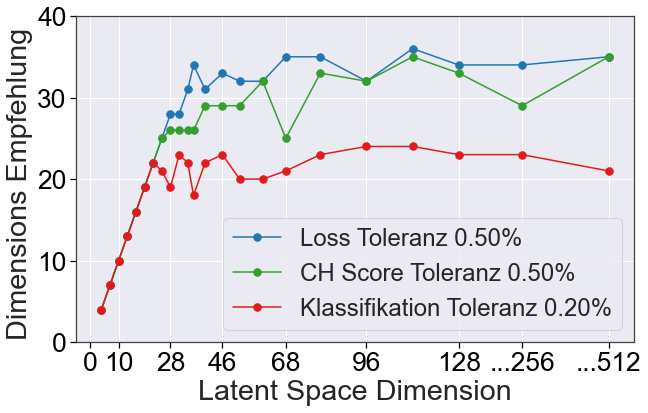

In [272]:

sns.set_palette("tab10")
sns.set_palette("Paired")
sns.set_palette(sns.color_palette("Paired")[1::2])
fig = plt.figure(figsize=(10,6))
plot_functions.fontscale(2.4, 24)
for test_name, test_dict in tolerances.items():
    #for train_test in ["Test", "Train"]: # saturated values are Train values
    for train_test in ["Test", "Train", ]:
        for suggested, tolvalue in zip(test_dict[train_test], test_dict['Niveaus']):
            if X_TYPE == 'DECODER_L1_VALUE':
                plt.plot(X_values[START:] , suggested, ".-", markersize=15,
                         label=test_name+" Toleranz "+format(tolvalue*100, ".2f")+"%" if train_test == "Train" else None)
            else:
                plt.plot(list(latent_sizes[START:-2]) + [150, 180], suggested, ".-", markersize=15,
                         label=test_name+" Toleranz "+format(tolvalue*100, ".2f")+"%")


ax = plt.gca()
#plt.xscale('log')
#plt.ylim(-1, 45)
plt.legend()
plt.legend(loc="lower right")
plt.ylim(0, 40)

#ax.yaxis.set_major_locator(MaxNLocator(integer=True)) # integer y axis
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
#plt.ylim(0, 40)
plt.xlabel("Latent Size of Model")
plt.ylabel("Dimensions Empfehlung ")
plt.xlabel("Latent Space Dimension des Modells")
set_xaxis()
#plt.xscale('linear')
if X_TYPE == 'LATENT_LAYER_SIZE':
    plt.yticks(range(0,50,10), range(0,50,10))
    plt.xticks([0, 10, 28, 46, 68, 96, 128, 150, 180], [0, 10, 28, 46, 68, 96, 128, "...256", "...512"])
else:
    ticks, labels = plt.xticks([10**-i for i in range(2,11,2)], ["$\mathdefault{10^{-"+str(i)+"}}$" for i in range(2,9, 2)]+["Ohne"])
plt.show()
#plot_functions.save_plot(FULL_PLOT_PATH+r"SuggestedSize_ToleranzLevels.svg", fig, bbox_inches='tight')